# CNN From Scratch vs Transfer Learning - Cats vs Dogs

## Objectif
Comparer deux approches de classification d'images :
1. **CNN from scratch** : Architecture personnalisée entraînée de zéro
2. **Transfer Learning** : Modèle pré-entraîné (MobileNetV2) adapté

##  Expérimentations
- 2 optimiseurs (SGD et Adam)
- Learning rate scheduler
- Régularisation (Dropout + Batch Normalization)
- Métriques complètes (Loss, Accuracy, Precision, Recall, F1-Score)
- Data augmentation



##  1. Configuration & Imports

In [2]:
# Installation des dépendances (si nécessaire)
import sys
!{sys.executable} -m pip install -q tensorboard scikit-learn seaborn

print(" Installation terminée!")

 Installation terminée!


In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings('ignore')

print(f" PyTorch version: {torch.__version__}")
print(f" TorchVision version: {torchvision.__version__}")
print(f" Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

if not torch.cuda.is_available():
    print(" GPU non détecté! Allez dans Runtime → Change runtime type → GPU")
else:
    print(" GPU activé! Tout est prêt!")

 PyTorch version: 2.8.0+cu126
 TorchVision version: 0.23.0+cu126
 Device: Tesla T4
 GPU activé! Tout est prêt!


##  2. Reproductibilité - Fixer le Seed

In [4]:
def set_seed(seed=42):
    """Fixe le seed pour la reproductibilité"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f" Seed fixé à {seed}")

set_seed(42)

 Seed fixé à 42


##  3. Configuration Globale

In [5]:
# 1. Vérifier le device (GPU ou CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Device utilisé: {device}")

if torch.cuda.is_available():
    print(f" GPU détecté: {torch.cuda.get_device_name(0)}")
else:
    print("  GPU non détecté - Entraînement sur CPU (plus lent)")

# 2. Configuration des hyperparamètres
CONFIG = {
    'IMG_SIZE': 224,           # Taille des images (224x224 pixels)
    'BATCH_SIZE': 64,          # Nombre d'images par batch
    'EPOCHS': 20,              # Nombre d'époques d'entraînement
    'LEARNING_RATE': 0.001,    # Taux d'apprentissage
    'NUM_CLASSES': 2,          # Nombre de classes (chat et chien)
    'TRAIN_VAL_SPLIT': 0.85,   # 85% train, 15% validation
    'NUM_WORKERS': 2,          # Nombre de workers pour charger les données
    'SEED': 42,                # Seed pour reproductibilité
    'DROPOUT': 0.5,            # Taux de dropout (régularisation)
    'WEIGHT_DECAY': 1e-4,      # Weight decay (régularisation L2)
}

# 3. Définir les chemins de sauvegarde
PATHS = {
    'DATA_DIR': '/content/Cat_Dog_Data',              # Données
    'OUTPUT_DIR': '/content/outputs',                 # Sorties générales
    'CHECKPOINTS_DIR': '/content/outputs/checkpoints', # Modèles sauvegardés
    'PLOTS_DIR': '/content/outputs/plots',            # Graphiques
}

# 4. Créer les dossiers s'ils n'existent pas
for key in ['OUTPUT_DIR', 'CHECKPOINTS_DIR', 'PLOTS_DIR']:
    os.makedirs(PATHS[key], exist_ok=True)

print("\n Configuration chargée:")
print("="*60)
for key, value in CONFIG.items():
    print(f"  {key:20s} : {value}")

print("\n Chemins configurés:")
print("="*60)
for key, value in PATHS.items():
    print(f"  {key:20s} : {value}")

print("\n Configuration terminée!")

  Device utilisé: cuda
 GPU détecté: Tesla T4

 Configuration chargée:
  IMG_SIZE             : 224
  BATCH_SIZE           : 64
  EPOCHS               : 20
  LEARNING_RATE        : 0.001
  NUM_CLASSES          : 2
  TRAIN_VAL_SPLIT      : 0.85
  NUM_WORKERS          : 2
  SEED                 : 42
  DROPOUT              : 0.5
  WEIGHT_DECAY         : 0.0001

 Chemins configurés:
  DATA_DIR             : /content/Cat_Dog_Data
  OUTPUT_DIR           : /content/outputs
  CHECKPOINTS_DIR      : /content/outputs/checkpoints
  PLOTS_DIR            : /content/outputs/plots

 Configuration terminée!


##  4. Téléchargement des Données depuis Kaggle

In [6]:
from google.colab import files

print(" Veuillez uploader votre fichier kaggle.json")
print("\n Comment obtenir kaggle.json ?")
print("   1. Allez sur https://www.kaggle.com")
print("   2. Connectez-vous à votre compte")
print("   3. Cliquez sur votre photo de profil (en haut à droite)")
print("   4. Allez dans 'Settings'")
print("   5. Scrollez jusqu'à 'API'")
print("   6. Cliquez sur 'Create New Token'")
print("   7. Un fichier kaggle.json sera téléchargé")
print("\n Cliquez sur 'Choisir les fichiers' ci-dessous et uploadez kaggle.json\n")

uploaded = files.upload()

# Configurer Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n Clé API Kaggle configurée avec succès!")

 Veuillez uploader votre fichier kaggle.json

 Comment obtenir kaggle.json ?
   1. Allez sur https://www.kaggle.com
   2. Connectez-vous à votre compte
   3. Cliquez sur votre photo de profil (en haut à droite)
   4. Allez dans 'Settings'
   5. Scrollez jusqu'à 'API'
   6. Cliquez sur 'Create New Token'
   7. Un fichier kaggle.json sera téléchargé

 Cliquez sur 'Choisir les fichiers' ci-dessous et uploadez kaggle.json



Saving kaggle.json to kaggle.json

 Clé API Kaggle configurée avec succès!


In [7]:
# Installer l'API Kaggle
!pip install -q kaggle

print(" Téléchargement d'un dataset Dogs vs Cats accessible...")
print("  Cela peut prendre 2-3 minutes...\n")

# Option 1 : Essayer le dataset Microsoft
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

# Si ça ne marche pas, essayons une autre source
if not os.path.exists('microsoft-catsvsdogs-dataset.zip'):
    print("\n Essai d'une autre source...")
    !kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

print("\n Téléchargement terminé!")

 Téléchargement d'un dataset Dogs vs Cats accessible...
  Cela peut prendre 2-3 minutes...

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 97% 763M/788M [00:03<00:00, 133MB/s]
100% 788M/788M [00:03<00:00, 212MB/s]

 Téléchargement terminé!


In [8]:
import zipfile
from glob import glob

print(" Extraction du dataset Microsoft...")

# Extraire le fichier
with zipfile.ZipFile('microsoft-catsvsdogs-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset_raw/')

print(" Extraction terminée!\n")

# Explorer la structure
print(" Structure du dataset extrait:")
!ls -lh /content/dataset_raw/

print("\n Sous-dossiers:")
!find /content/dataset_raw -type d | head -10

 Extraction du dataset Microsoft...
 Extraction terminée!

 Structure du dataset extrait:
total 44K
-rw-r--r-- 1 root root  35K Oct 18 20:38 'MSR-LA - 3467.docx'
drwxr-xr-x 4 root root 4.0K Oct 18 20:38  PetImages
-rw-r--r-- 1 root root  104 Oct 18 20:38 'readme[1].txt'

 Sous-dossiers:
/content/dataset_raw
/content/dataset_raw/PetImages
/content/dataset_raw/PetImages/Cat
/content/dataset_raw/PetImages/Dog


In [9]:
import shutil

print(" Organisation des images dans la structure requise...\n")

# Créer la structure
os.makedirs('/content/Cat_Dog_Data/train/cat', exist_ok=True)
os.makedirs('/content/Cat_Dog_Data/train/dog', exist_ok=True)
os.makedirs('/content/Cat_Dog_Data/test/cat', exist_ok=True)
os.makedirs('/content/Cat_Dog_Data/test/dog', exist_ok=True)

# Récupérer toutes les images
cat_files = glob('/content/dataset_raw/PetImages/Cat/*.jpg')
dog_files = glob('/content/dataset_raw/PetImages/Dog/*.jpg')

print(f" Images trouvées:")
print(f"   • Chats: {len(cat_files):,} images")
print(f"   • Chiens: {len(dog_files):,} images")
print(f"   • Total: {len(cat_files) + len(dog_files):,} images\n")

# Diviser en train (90%) et test (10%)
split_idx_cat = int(len(cat_files) * 0.9)
split_idx_dog = int(len(dog_files) * 0.9)

cat_train = cat_files[:split_idx_cat]
cat_test = cat_files[split_idx_cat:]
dog_train = dog_files[:split_idx_dog]
dog_test = dog_files[split_idx_dog:]

# Copier vers train
print(" Copie vers TRAIN...")
for file in tqdm(cat_train, desc="Train cats"):
    try:
        shutil.copy(file, '/content/Cat_Dog_Data/train/cat/')
    except:
        pass  # Ignorer les fichiers corrompus

for file in tqdm(dog_train, desc="Train dogs"):
    try:
        shutil.copy(file, '/content/Cat_Dog_Data/train/dog/')
    except:
        pass

# Copier vers test
print("\n Copie vers TEST...")
for file in tqdm(cat_test, desc="Test cats"):
    try:
        shutil.copy(file, '/content/Cat_Dog_Data/test/cat/')
    except:
        pass

for file in tqdm(dog_test, desc="Test dogs"):
    try:
        shutil.copy(file, '/content/Cat_Dog_Data/test/dog/')
    except:
        pass

# Statistiques finales
train_cats = len(os.listdir('/content/Cat_Dog_Data/train/cat'))
train_dogs = len(os.listdir('/content/Cat_Dog_Data/train/dog'))
test_cats = len(os.listdir('/content/Cat_Dog_Data/test/cat'))
test_dogs = len(os.listdir('/content/Cat_Dog_Data/test/dog'))

print(f"\n{'='*60}")
print(" STATISTIQUES FINALES DU DATASET")
print(f"{'='*60}")
print(f"  🔹 TRAIN:")
print(f"     • Chats: {train_cats:,} images")
print(f"     • Chiens: {train_dogs:,} images")
print(f"     • Total: {train_cats + train_dogs:,} images")
print(f"\n  🔹 TEST:")
print(f"     • Chats: {test_cats:,} images")
print(f"     • Chiens: {test_dogs:,} images")
print(f"     • Total: {test_cats + test_dogs:,} images")
print(f"{'='*60}")
print("\n Données organisées et prêtes pour l'entraînement!")

 Organisation des images dans la structure requise...

 Images trouvées:
   • Chats: 12,500 images
   • Chiens: 12,500 images
   • Total: 25,000 images

 Copie vers TRAIN...


Train cats:   0%|          | 0/11250 [00:00<?, ?it/s]

Train dogs:   0%|          | 0/11250 [00:00<?, ?it/s]


 Copie vers TEST...


Test cats:   0%|          | 0/1250 [00:00<?, ?it/s]

Test dogs:   0%|          | 0/1250 [00:00<?, ?it/s]


 STATISTIQUES FINALES DU DATASET
  🔹 TRAIN:
     • Chats: 11,250 images
     • Chiens: 11,250 images
     • Total: 22,500 images

  🔹 TEST:
     • Chats: 1,250 images
     • Chiens: 1,250 images
     • Total: 2,500 images

 Données organisées et prêtes pour l'entraînement!


##  5. Data Augmentation & DataLoaders

In [11]:
from torchvision import transforms

print(" Création des transformations pour les images...\n")

# Transforms pour l'ENTRAÎNEMENT (avec augmentation)
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),  # Redimensionner à 224x224
    transforms.RandomHorizontalFlip(p=0.5),                       # Flip horizontal (50% chance)
    transforms.RandomRotation(degrees=15),                        # Rotation aléatoire ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Variation couleurs
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),    # Translation légère
    transforms.ToTensor(),                                        # Convertir en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],             # Normalisation ImageNet
                        std=[0.229, 0.224, 0.225])
])

# Transforms pour VALIDATION/TEST (sans augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print(" Transformations créées:")
print("    TRAIN : Resize, Flip, Rotation, ColorJitter, Affine, Normalize")
print("    VAL/TEST : Resize, Normalize uniquement")

 Création des transformations pour les images...

 Transformations créées:
    TRAIN : Resize, Flip, Rotation, ColorJitter, Affine, Normalize
    VAL/TEST : Resize, Normalize uniquement


In [12]:
from torchvision import datasets

print(" Chargement des datasets...\n")

# Charger le dataset d'entraînement complet
full_train_dataset = datasets.ImageFolder(
    root='/content/Cat_Dog_Data/train',
    transform=train_transform
)

# Dataset de test
test_dataset = datasets.ImageFolder(
    root='/content/Cat_Dog_Data/test',
    transform=val_test_transform
)

print(f" Datasets chargés:")
print(f"   • Train (complet): {len(full_train_dataset):,} images")
print(f"   • Test: {len(test_dataset):,} images")
print(f"\n  Classes détectées: {full_train_dataset.classes}")
print(f"   Mapping: {full_train_dataset.class_to_idx}")

 Chargement des datasets...

 Datasets chargés:
   • Train (complet): 22,500 images
   • Test: 2,500 images

  Classes détectées: ['cat', 'dog']
   Mapping: {'cat': 0, 'dog': 1}


In [13]:
from torch.utils.data import random_split

print("  Split Train/Validation...\n")

# Calculer les tailles
train_size = int(CONFIG['TRAIN_VAL_SPLIT'] * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

print(f" Répartition:")
print(f"   • Train: {CONFIG['TRAIN_VAL_SPLIT']*100:.0f}% = {train_size:,} images")
print(f"   • Validation: {(1-CONFIG['TRAIN_VAL_SPLIT'])*100:.0f}% = {val_size:,} images\n")

# Faire le split
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(CONFIG['SEED'])
)

print(f" Split effectué:")
print(f"   • Train: {len(train_dataset):,} images")
print(f"   • Validation: {len(val_dataset):,} images")
print(f"   • Test: {len(test_dataset):,} images")

  Split Train/Validation...

 Répartition:
   • Train: 85% = 19,125 images
   • Validation: 15% = 3,375 images

 Split effectué:
   • Train: 19,125 images
   • Validation: 3,375 images
   • Test: 2,500 images


In [14]:
from torch.utils.data import DataLoader

print(" Création des DataLoaders...\n")

# DataLoader pour l'entraînement
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,                          # Mélanger les données
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True                        # Optimisation pour GPU
)

# DataLoader pour la validation
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,                         # Pas de mélange pour validation
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

# DataLoader pour le test
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

print(f" DataLoaders créés:")
print(f"   • Batch size: {CONFIG['BATCH_SIZE']}")
print(f"   • Train batches: {len(train_loader):,}")
print(f"   • Val batches: {len(val_loader):,}")
print(f"   • Test batches: {len(test_loader):,}")
print(f"\n Chaque batch contient {CONFIG['BATCH_SIZE']} images")

 Création des DataLoaders...

 DataLoaders créés:
   • Batch size: 64
   • Train batches: 299
   • Val batches: 53
   • Test batches: 40

 Chaque batch contient 64 images


 Forme d'un batch:
   • Images: torch.Size([64, 3, 224, 224])
   • Labels: torch.Size([64])



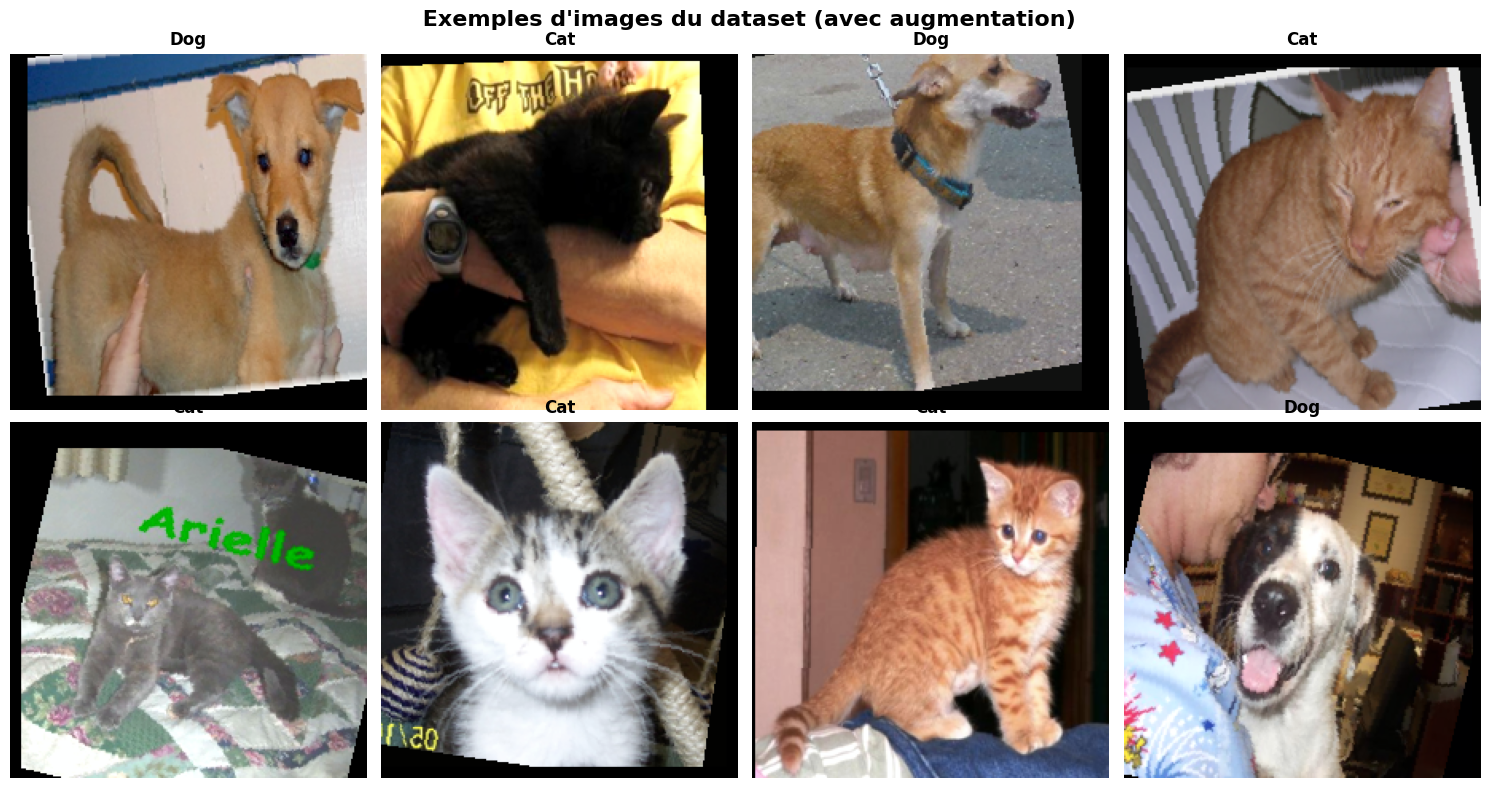

 Visualisation sauvegardée dans: /content/outputs/plots


In [15]:
def imshow(img):
    """Afficher une image tensor"""
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Obtenir un batch
images, labels = next(iter(train_loader))

print(f" Forme d'un batch:")
print(f"   • Images: {images.shape}")
print(f"   • Labels: {labels.shape}\n")

# Afficher 8 images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
class_names = ['Cat', 'Dog']

for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(imshow(images[idx]))
        ax.set_title(f"{class_names[labels[idx]]}", fontsize=12, fontweight='bold')
        ax.axis('off')

plt.suptitle(' Exemples d\'images du dataset (avec augmentation)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PATHS['PLOTS_DIR'], 'sample_images.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print(" Visualisation sauvegardée dans:", PATHS['PLOTS_DIR'])

### 5.5 Nettoyage des Images Corrompues

In [16]:
from PIL import Image

print(" Nettoyage du dataset - Suppression des images corrompues...\n")

def remove_corrupted_images(directory):
    """Supprime les images corrompues d'un dossier"""
    removed_count = 0
    total_count = 0

    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(root, filename)
                total_count += 1

                try:
                    # Essayer d'ouvrir l'image
                    img = Image.open(filepath)
                    img.verify()  # Vérifier que l'image est valide
                    img.close()
                except Exception as e:
                    # Supprimer si corrompue
                    print(f" Suppression: {filepath}")
                    os.remove(filepath)
                    removed_count += 1

    return total_count, removed_count

# Nettoyer train
print(" Nettoyage de TRAIN...")
train_total, train_removed = remove_corrupted_images('/content/Cat_Dog_Data/train')

# Nettoyer test
print("\n Nettoyage de TEST...")
test_total, test_removed = remove_corrupted_images('/content/Cat_Dog_Data/test')

print(f"\n{'='*60}")
print(" Nettoyage terminé!")
print(f"{'='*60}")
print(f"  Train: {train_removed}/{train_total} images supprimées")
print(f"  Test:  {test_removed}/{test_total} images supprimées")
print(f"  Total: {train_removed + test_removed} images corrompues retirées")
print(f"{'='*60}\n")

# Statistiques après nettoyage
train_cats = len(os.listdir('/content/Cat_Dog_Data/train/cat'))
train_dogs = len(os.listdir('/content/Cat_Dog_Data/train/dog'))
test_cats = len(os.listdir('/content/Cat_Dog_Data/test/cat'))
test_dogs = len(os.listdir('/content/Cat_Dog_Data/test/dog'))

print(" Dataset après nettoyage:")
print(f"  Train: {train_cats} chats + {train_dogs} chiens = {train_cats + train_dogs} total")
print(f"  Test:  {test_cats} chats + {test_dogs} chiens = {test_cats + test_dogs} total")

 Nettoyage du dataset - Suppression des images corrompues...

 Nettoyage de TRAIN...
 Suppression: /content/Cat_Dog_Data/train/cat/666.jpg

 Nettoyage de TEST...
 Suppression: /content/Cat_Dog_Data/test/dog/11702.jpg

 Nettoyage terminé!
  Train: 1/22500 images supprimées
  Test:  1/2500 images supprimées
  Total: 2 images corrompues retirées

 Dataset après nettoyage:
  Train: 11249 chats + 11250 chiens = 22499 total
  Test:  1250 chats + 1249 chiens = 2499 total


In [17]:
print(" Recréation des DataLoaders avec le dataset nettoyé...\n")

# Recharger les datasets (avec les mêmes transforms !)
full_train_dataset = datasets.ImageFolder(
    root='/content/Cat_Dog_Data/train',
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root='/content/Cat_Dog_Data/test',
    transform=val_test_transform
)

# Re-split train/validation
train_size = int(CONFIG['TRAIN_VAL_SPLIT'] * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(CONFIG['SEED'])
)

# Recréer les DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

print(f" DataLoaders recréés!")
print(f"   Train: {len(train_dataset):,} images")
print(f"   Val:   {len(val_dataset):,} images")
print(f"   Test:  {len(test_dataset):,} images")
print("\n Prêt pour l'entraînement!")

 Recréation des DataLoaders avec le dataset nettoyé...

 DataLoaders recréés!
   Train: 19,124 images
   Val:   3,375 images
   Test:  2,499 images

 Prêt pour l'entraînement!


##  6. Architecture CNN From Scratch

In [18]:
class CNNFromScratch(nn.Module):
    """
    CNN personnalisé avec 4 blocs convolutionnels
    + Batch Normalization + Dropout pour régularisation
    """

    def __init__(self, num_classes=2, dropout=0.5):
        super(CNNFromScratch, self).__init__()

        # BLOC 1 : 3 → 32 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),      # Conv 3→32
            nn.BatchNorm2d(32),                               # BatchNorm
            nn.ReLU(inplace=True),                            # Activation
            nn.Conv2d(32, 32, kernel_size=3, padding=1),     # Conv 32→32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),           # Réduction /2
            nn.Dropout2d(p=0.25)                             # Dropout spatial
        )

        # BLOC 2 : 32 → 64 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25)
        )

        # BLOC 3 : 64 → 128 channels
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25)
        )

        # BLOC 4 : 128 → 256 channels
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25)
        )

        # Global Average Pooling (remplace Flatten)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier (couches fully connected)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """Propagation avant"""
        x = self.block1(x)      # 224x224 → 112x112
        x = self.block2(x)      # 112x112 → 56x56
        x = self.block3(x)      # 56x56 → 28x28
        x = self.block4(x)      # 28x28 → 14x14
        x = self.global_avg_pool(x)  # 14x14 → 1x1
        x = self.classifier(x)  # Classification
        return x

print(" Classe CNNFromScratch définie!")

 Classe CNNFromScratch définie!


In [19]:
# Créer une instance du modèle
model_test = CNNFromScratch(
    num_classes=CONFIG['NUM_CLASSES'],
    dropout=CONFIG['DROPOUT']
)
model_test = model_test.to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model_test.parameters())
trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)

print("  CNN From Scratch - Résumé:")
print("="*60)
print(f"   • Total paramètres: {total_params:,}")
print(f"   • Paramètres entraînables: {trainable_params:,}")
print(f"   • Nombre de couches: {len(list(model_test.modules()))}")
print("="*60)

# Tester avec un batch
test_input = torch.randn(4, 3, 224, 224).to(device)  # 4 images de test
test_output = model_test(test_input)

print(f"\n Test de propagation:")
print(f"   • Input shape: {test_input.shape}")
print(f"   • Output shape: {test_output.shape}")
print(f"   • Output (logits): {test_output[0].detach().cpu().numpy()}")

print("\n Modèle CNN from scratch fonctionnel!")

# Afficher l'architecture complète
print("\n Architecture détaillée:")
print(model_test)

  CNN From Scratch - Résumé:
   • Total paramètres: 782,370
   • Paramètres entraînables: 782,370
   • Nombre de couches: 46

 Test de propagation:
   • Input shape: torch.Size([4, 3, 224, 224])
   • Output shape: torch.Size([4, 2])
   • Output (logits): [-0.9096398   0.52419543]

 Modèle CNN from scratch fonctionnel!

 Architecture détaillée:
CNNFromScratch(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

##  7. Transfer Learning avec MobileNetV2

In [20]:
class TransferLearningModel(nn.Module):
    """
    Transfer Learning avec MobileNetV2 pré-entraîné sur ImageNet
    """

    def __init__(self, num_classes=2, dropout=0.5, freeze_backbone=True):
        super(TransferLearningModel, self).__init__()

        # Charger MobileNetV2 pré-entraîné
        self.backbone = models.mobilenet_v2(pretrained=True)

        # Geler les couches du backbone si demandé
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print(" Backbone gelé (frozen) - Seules les couches finales seront entraînées")
        else:
            print(" Backbone dégelé - Toutes les couches seront entraînées")

        # Remplacer le classifier original
        in_features = self.backbone.classifier[1].in_features  # 1280 pour MobileNetV2

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """Propagation avant"""
        return self.backbone(x)

print(" Classe TransferLearningModel définie!")

 Classe TransferLearningModel définie!


In [21]:
# Créer une instance du modèle
transfer_model_test = TransferLearningModel(
    num_classes=CONFIG['NUM_CLASSES'],
    dropout=CONFIG['DROPOUT'],
    freeze_backbone=True  # On gèle le backbone
)
transfer_model_test = transfer_model_test.to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in transfer_model_test.parameters())
trainable_params = sum(p.numel() for p in transfer_model_test.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("\n Transfer Learning (MobileNetV2) - Résumé:")
print("="*60)
print(f"   • Total paramètres: {total_params:,}")
print(f"   • Paramètres entraînables: {trainable_params:,}")
print(f"   • Paramètres gelés: {frozen_params:,}")
print(f"   • Ratio entraînable: {(trainable_params/total_params)*100:.1f}%")
print("="*60)

# Tester avec un batch
test_input = torch.randn(4, 3, 224, 224).to(device)
test_output = transfer_model_test(test_input)

print(f"\n Test de propagation:")
print(f"   • Input shape: {test_input.shape}")
print(f"   • Output shape: {test_output.shape}")
print(f"   • Output (logits): {test_output[0].detach().cpu().numpy()}")

print("\n Modèle Transfer Learning fonctionnel!")

# Comparaison avec CNN from scratch
print(f"\n Comparaison:")
print(f"   CNN from scratch : {sum(p.numel() for p in model_test.parameters()):,} paramètres")
print(f"   Transfer Learning: {trainable_params:,} paramètres entraînables")
print(f"   Réduction: {((1 - trainable_params/sum(p.numel() for p in model_test.parameters()))*100):.1f}% de paramètres en moins à entraîner")



Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 172MB/s]


 Backbone gelé (frozen) - Seules les couches finales seront entraînées

 Transfer Learning (MobileNetV2) - Résumé:
   • Total paramètres: 2,881,794
   • Paramètres entraînables: 657,922
   • Paramètres gelés: 2,223,872
   • Ratio entraînable: 22.8%

 Test de propagation:
   • Input shape: torch.Size([4, 3, 224, 224])
   • Output shape: torch.Size([4, 2])
   • Output (logits): [-0.07545517  0.26142135]

 Modèle Transfer Learning fonctionnel!

 Comparaison:
   CNN from scratch : 782,370 paramètres
   Transfer Learning: 657,922 paramètres entraînables
   Réduction: 15.9% de paramètres en moins à entraîner


##  8. Fonctions d'Entraînement et Évaluation

In [22]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Entraîne le modèle pour une époque

    Args:
        model: Le modèle à entraîner
        dataloader: DataLoader du train set
        criterion: Fonction de loss
        optimizer: Optimiseur (SGD ou Adam)
        device: CPU ou GPU

    Returns:
        loss, accuracy, precision, recall, f1
    """
    model.train()  # Mode entraînement (active dropout, batchnorm, etc.)

    running_loss = 0.0
    all_preds = []
    all_labels = []

    # Barre de progression
    pbar = tqdm(dataloader, desc='Training', leave=False)

    for images, labels in pbar:
        # Déplacer sur GPU
        images, labels = images.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Métriques
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Mettre à jour la barre
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer les métriques moyennes
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1

print(" Fonction train_epoch créée!")

 Fonction train_epoch créée!


In [23]:
def validate_epoch(model, dataloader, criterion, device):
    """
    Évalue le modèle sur le validation set

    Args:
        model: Le modèle à évaluer
        dataloader: DataLoader du validation set
        criterion: Fonction de loss
        device: CPU ou GPU

    Returns:
        loss, accuracy, precision, recall, f1, predictions, labels
    """
    model.eval()  # Mode évaluation (désactive dropout, batchnorm en mode inference)

    running_loss = 0.0
    all_preds = []
    all_labels = []

    # Pas de calcul de gradients pendant la validation
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass uniquement
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Métriques
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer les métriques
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1, all_preds, all_labels

print("Fonction validate_epoch créée!")

Fonction validate_epoch créée!


In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, model_name, save_path):
    """
    Boucle d'entraînement complète avec sauvegarde du meilleur modèle

    Args:
        model: Modèle à entraîner
        train_loader: DataLoader train
        val_loader: DataLoader validation
        criterion: Loss function
        optimizer: Optimiseur
        scheduler: Learning rate scheduler
        num_epochs: Nombre d'époques
        device: CPU ou GPU
        model_name: Nom du modèle (pour affichage)
        save_path: Chemin pour sauvegarder le modèle

    Returns:
        history: Dictionnaire avec toutes les métriques
        best_val_acc: Meilleure accuracy de validation
    """

    # Historique des métriques
    history = {
        'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': [],
        'lr': []
    }

    best_val_acc = 0.0
    best_epoch = 0
    patience = 5  # Early stopping
    patience_counter = 0

    print(f"\n{'='*70}")
    print(f" Début de l'entraînement: {model_name}")
    print(f"{'='*70}\n")

    for epoch in range(num_epochs):
        start_time = datetime.now()

        # ENTRAÎNEMENT
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # VALIDATION
        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = validate_epoch(
            model, val_loader, criterion, device
        )

        # Learning rate scheduler
        if scheduler:
            scheduler.step()

        # Sauvegarder l'historique
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_prec)
        history['train_recall'].append(train_rec)
        history['train_f1'].append(train_f1)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)

        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Sauvegarder le meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'history': history
            }, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        # Affichage
        elapsed = (datetime.now() - start_time).total_seconds()
        print(f"Epoch [{epoch+1}/{num_epochs}] - {elapsed:.1f}s")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}, F1={train_f1:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f} | Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")

        # Early stopping
        if patience_counter >= patience:
            print(f"\n Early stopping déclenché après {epoch+1} epochs (pas d'amélioration depuis {patience} epochs)")
            break

        print()

    print(f"{'='*70}")
    print(f" Entraînement terminé!")
    print(f" Meilleure validation accuracy: {best_val_acc:.4f} à l'epoch {best_epoch}")
    print(f" Modèle sauvegardé: {save_path}")
    print(f"{'='*70}\n")

    return history, best_val_acc

print("Fonction train_model créée!")


Fonction train_model créée!


##  9. Entraînement des 4 Modèles

### Configurations à entraîner :
1. CNN From Scratch + SGD
2. CNN From Scratch + Adam
3. Transfer Learning + SGD
4. Transfer Learning + Adam

In [25]:
print("="*70)
print(" EXPÉRIENCE 1/4 : CNN FROM SCRATCH + SGD")
print("="*70)

# Créer le modèle
model_scratch_sgd = CNNFromScratch(
    num_classes=CONFIG['NUM_CLASSES'],
    dropout=CONFIG['DROPOUT']
).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiseur SGD avec momentum
optimizer_sgd = optim.SGD(
    model_scratch_sgd.parameters(),
    lr=CONFIG['LEARNING_RATE'],
    momentum=0.9,
    weight_decay=CONFIG['WEIGHT_DECAY']
)

# Scheduler StepLR (réduit le LR tous les 7 epochs)
scheduler_sgd = StepLR(optimizer_sgd, step_size=7, gamma=0.1)

# Chemin de sauvegarde
save_path_sgd = os.path.join(PATHS['CHECKPOINTS_DIR'], 'cnn_scratch_sgd_best.pt')

# ENTRAÎNEMENT
history_scratch_sgd, best_acc_sgd = train_model(
    model=model_scratch_sgd,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_sgd,
    scheduler=scheduler_sgd,
    num_epochs=CONFIG['EPOCHS'],
    device=device,
    model_name="CNN From Scratch + SGD",
    save_path=save_path_sgd
)

print(f" Expérience 1 terminée! Best Val Acc: {best_acc_sgd:.4f}")

 EXPÉRIENCE 1/4 : CNN FROM SCRATCH + SGD

 Début de l'entraînement: CNN From Scratch + SGD



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [1/20] - 153.1s
  Train: Loss=0.6943, Acc=0.5561, Prec=0.5613, Rec=0.5097, F1=0.5343
  Val:   Loss=0.6943, Acc=0.5461, Prec=0.8942, Rec=0.1097, F1=0.1954
  LR: 0.001000 | Best Val Acc: 0.5461 (Epoch 1)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [2/20] - 157.0s
  Train: Loss=0.6688, Acc=0.5796, Prec=0.6008, Rec=0.4722, F1=0.5288
  Val:   Loss=0.6962, Acc=0.5487, Prec=0.9261, Rec=0.1108, F1=0.1980
  LR: 0.001000 | Best Val Acc: 0.5487 (Epoch 2)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [3/20] - 166.3s
  Train: Loss=0.6600, Acc=0.5940, Prec=0.6168, Rec=0.4947, F1=0.5490
  Val:   Loss=0.7086, Acc=0.5437, Prec=0.9239, Rec=0.1002, F1=0.1809
  LR: 0.001000 | Best Val Acc: 0.5487 (Epoch 2)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [4/20] - 156.4s
  Train: Loss=0.6538, Acc=0.6017, Prec=0.6272, Rec=0.4995, F1=0.5561
  Val:   Loss=0.7112, Acc=0.5404, Prec=0.9191, Rec=0.0938, F1=0.1701
  LR: 0.001000 | Best Val Acc: 0.5487 (Epoch 2)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [5/20] - 154.4s
  Train: Loss=0.6476, Acc=0.6155, Prec=0.6427, Rec=0.5184, F1=0.5739
  Val:   Loss=0.7141, Acc=0.5437, Prec=0.9149, Rec=0.1014, F1=0.1826
  LR: 0.001000 | Best Val Acc: 0.5487 (Epoch 2)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [6/20] - 159.7s
  Train: Loss=0.6406, Acc=0.6258, Prec=0.6534, Rec=0.5346, F1=0.5881
  Val:   Loss=0.7237, Acc=0.5458, Prec=0.9454, Rec=0.1020, F1=0.1841
  LR: 0.001000 | Best Val Acc: 0.5487 (Epoch 2)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [7/20] - 167.8s
  Train: Loss=0.6365, Acc=0.6326, Prec=0.6538, Rec=0.5621, F1=0.6045
  Val:   Loss=0.7098, Acc=0.5612, Prec=0.9388, Rec=0.1356, F1=0.2370
  LR: 0.000100 | Best Val Acc: 0.5612 (Epoch 7)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [8/20] - 171.8s
  Train: Loss=0.6309, Acc=0.6322, Prec=0.6548, Rec=0.5579, F1=0.6025
  Val:   Loss=0.7298, Acc=0.5487, Prec=0.9482, Rec=0.1079, F1=0.1938
  LR: 0.000100 | Best Val Acc: 0.5612 (Epoch 7)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^^^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    AssertionError
if 

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [9/20] - 173.5s
  Train: Loss=0.6301, Acc=0.6402, Prec=0.6646, Rec=0.5651, F1=0.6108
  Val:   Loss=0.7363, Acc=0.5449, Prec=0.9444, Rec=0.1002, F1=0.1812
  LR: 0.000100 | Best Val Acc: 0.5612 (Epoch 7)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [10/20] - 154.9s
  Train: Loss=0.6307, Acc=0.6349, Prec=0.6597, Rec=0.5558, F1=0.6033
  Val:   Loss=0.7361, Acc=0.5487, Prec=0.9482, Rec=0.1079, F1=0.1938
  LR: 0.000100 | Best Val Acc: 0.5612 (Epoch 7)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [11/20] - 155.2s
  Train: Loss=0.6308, Acc=0.6371, Prec=0.6597, Rec=0.5651, F1=0.6087
  Val:   Loss=0.7380, Acc=0.5404, Prec=0.9560, Rec=0.0896, F1=0.1639
  LR: 0.000100 | Best Val Acc: 0.5612 (Epoch 7)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [12/20] - 159.5s
  Train: Loss=0.6304, Acc=0.6368, Prec=0.6597, Rec=0.5641, F1=0.6081
  Val:   Loss=0.7439, Acc=0.5384, Prec=0.9481, Rec=0.0861, F1=0.1578
  LR: 0.000100 | Best Val Acc: 0.5612 (Epoch 7)

 Early stopping déclenché après 12 epochs (pas d'amélioration depuis 5 epochs)
 Entraînement terminé!
 Meilleure validation accuracy: 0.5612 à l'epoch 7
 Modèle sauvegardé: /content/outputs/checkpoints/cnn_scratch_sgd_best.pt

 Expérience 1 terminée! Best Val Acc: 0.5612


In [26]:
print("\n" + "="*70)
print(" EXPÉRIENCE 2/4 : CNN FROM SCRATCH + ADAM")
print("="*70)

# Créer un NOUVEAU modèle (réinitialiser les poids)
model_scratch_adam = CNNFromScratch(
    num_classes=CONFIG['NUM_CLASSES'],
    dropout=CONFIG['DROPOUT']
).to(device)

# Optimiseur Adam
optimizer_adam = optim.Adam(
    model_scratch_adam.parameters(),
    lr=CONFIG['LEARNING_RATE'],
    weight_decay=CONFIG['WEIGHT_DECAY']
)

# Scheduler CosineAnnealing
scheduler_adam = CosineAnnealingLR(optimizer_adam, T_max=CONFIG['EPOCHS'])

# Chemin de sauvegarde
save_path_adam = os.path.join(PATHS['CHECKPOINTS_DIR'], 'cnn_scratch_adam_best.pt')

# ENTRAÎNEMENT
history_scratch_adam, best_acc_adam = train_model(
    model=model_scratch_adam,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_adam,
    scheduler=scheduler_adam,
    num_epochs=CONFIG['EPOCHS'],
    device=device,
    model_name="CNN From Scratch + Adam",
    save_path=save_path_adam
)

print(f" Expérience 2 terminée! Best Val Acc: {best_acc_adam:.4f}")


 EXPÉRIENCE 2/4 : CNN FROM SCRATCH + ADAM

 Début de l'entraînement: CNN From Scratch + Adam



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>self._shutdown_workers()

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [1/20] - 172.7s
  Train: Loss=0.6928, Acc=0.5629, Prec=0.5701, Rec=0.5087, F1=0.5376
  Val:   Loss=0.6461, Acc=0.6255, Prec=0.6742, Rec=0.4929, F1=0.5695
  LR: 0.000994 | Best Val Acc: 0.6255 (Epoch 1)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [2/20] - 158.7s
  Train: Loss=0.6573, Acc=0.6060, Prec=0.6215, Rec=0.5404, F1=0.5781
  Val:   Loss=0.6387, Acc=0.6196, Prec=0.6985, Rec=0.4275, F1=0.5304
  LR: 0.000976 | Best Val Acc: 0.6255 (Epoch 1)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [3/20] - 155.3s
  Train: Loss=0.6480, Acc=0.6212, Prec=0.6398, Rec=0.5531, F1=0.5933
  Val:   Loss=0.6280, Acc=0.6421, Prec=0.6655, Rec=0.5784, F1=0.6189
  LR: 0.000946 | Best Val Acc: 0.6421 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [4/20] - 155.8s
  Train: Loss=0.6400, Acc=0.6270, Prec=0.6478, Rec=0.5554, F1=0.5980
  Val:   Loss=0.6191, Acc=0.6563, Prec=0.6942, Rec=0.5649, F1=0.6229
  LR: 0.000905 | Best Val Acc: 0.6563 (Epoch 4)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^^ ^^^^^

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [5/20] - 166.3s
  Train: Loss=0.6309, Acc=0.6369, Prec=0.6536, Rec=0.5813, F1=0.6154
  Val:   Loss=0.6057, Acc=0.6723, Prec=0.6889, Rec=0.6344, F1=0.6605
  LR: 0.000854 | Best Val Acc: 0.6723 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [6/20] - 170.5s
  Train: Loss=0.6303, Acc=0.6397, Prec=0.6499, Rec=0.6042, F1=0.6262
  Val:   Loss=0.6177, Acc=0.6578, Prec=0.6859, Rec=0.5884, F1=0.6334
  LR: 0.000794 | Best Val Acc: 0.6723 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [7/20] - 172.0s
  Train: Loss=0.6193, Acc=0.6529, Prec=0.6700, Rec=0.6016, F1=0.6340
  Val:   Loss=0.6020, Acc=0.6631, Prec=0.6313, Rec=0.7925, F1=0.7027
  LR: 0.000727 | Best Val Acc: 0.6723 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [8/20] - 154.6s
  Train: Loss=0.6142, Acc=0.6562, Prec=0.6683, Rec=0.6191, F1=0.6428
  Val:   Loss=0.5939, Acc=0.6779, Prec=0.7781, Rec=0.5024, F1=0.6105
  LR: 0.000655 | Best Val Acc: 0.6779 (Epoch 8)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [9/20] - 156.1s
  Train: Loss=0.6028, Acc=0.6715, Prec=0.6902, Rec=0.6214, F1=0.6540
  Val:   Loss=0.5799, Acc=0.6865, Prec=0.7788, Rec=0.5254, F1=0.6275
  LR: 0.000578 | Best Val Acc: 0.6865 (Epoch 9)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [10/20] - 156.6s
  Train: Loss=0.5994, Acc=0.6735, Prec=0.6973, Rec=0.6122, F1=0.6520
  Val:   Loss=0.5701, Acc=0.7013, Prec=0.7443, Rec=0.6179, F1=0.6753
  LR: 0.000500 | Best Val Acc: 0.7013 (Epoch 10)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [11/20] - 171.4s
  Train: Loss=0.5879, Acc=0.6816, Prec=0.7000, Rec=0.6344, F1=0.6656
  Val:   Loss=0.5457, Acc=0.7265, Prec=0.7686, Rec=0.6521, F1=0.7056
  LR: 0.000422 | Best Val Acc: 0.7265 (Epoch 11)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):

    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():
     ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^

Epoch [12/20] - 175.4s
  Train: Loss=0.5783, Acc=0.6921, Prec=0.7167, Rec=0.6345, F1=0.6731
  Val:   Loss=0.5399, Acc=0.7221, Prec=0.7480, Rec=0.6739, F1=0.7091
  LR: 0.000345 | Best Val Acc: 0.7265 (Epoch 11)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: 
can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [13/20] - 173.1s
  Train: Loss=0.5691, Acc=0.6992, Prec=0.7194, Rec=0.6525, F1=0.6843
  Val:   Loss=0.5389, Acc=0.7197, Prec=0.7934, Rec=0.5979, F1=0.6819
  LR: 0.000273 | Best Val Acc: 0.7265 (Epoch 11)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [14/20] - 156.0s
  Train: Loss=0.5618, Acc=0.7113, Prec=0.7329, Rec=0.6641, F1=0.6968
  Val:   Loss=0.5284, Acc=0.7324, Prec=0.8090, Rec=0.6120, F1=0.6969
  LR: 0.000206 | Best Val Acc: 0.7324 (Epoch 14)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [15/20] - 156.4s
  Train: Loss=0.5490, Acc=0.7225, Prec=0.7448, Rec=0.6765, F1=0.7090
  Val:   Loss=0.5177, Acc=0.7416, Prec=0.7689, Rec=0.6946, F1=0.7299
  LR: 0.000146 | Best Val Acc: 0.7416 (Epoch 15)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [16/20] - 156.9s
  Train: Loss=0.5474, Acc=0.7233, Prec=0.7384, Rec=0.6910, F1=0.7139
  Val:   Loss=0.5049, Acc=0.7523, Prec=0.7863, Rec=0.6963, F1=0.7386
  LR: 0.000095 | Best Val Acc: 0.7523 (Epoch 16)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [17/20] - 164.6s
  Train: Loss=0.5362, Acc=0.7335, Prec=0.7543, Rec=0.6921, F1=0.7218
  Val:   Loss=0.4978, Acc=0.7570, Prec=0.8008, Rec=0.6875, F1=0.7398
  LR: 0.000054 | Best Val Acc: 0.7570 (Epoch 17)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [18/20] - 179.3s
  Train: Loss=0.5312, Acc=0.7364, Prec=0.7516, Rec=0.7055, F1=0.7278
  Val:   Loss=0.4931, Acc=0.7550, Prec=0.8235, Rec=0.6521, F1=0.7279
  LR: 0.000024 | Best Val Acc: 0.7570 (Epoch 17)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [19/20] - 177.8s
  Train: Loss=0.5263, Acc=0.7411, Prec=0.7596, Rec=0.7047, F1=0.7311
  Val:   Loss=0.4933, Acc=0.7624, Prec=0.8139, Rec=0.6834, F1=0.7429
  LR: 0.000006 | Best Val Acc: 0.7624 (Epoch 19)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [20/20] - 158.3s
  Train: Loss=0.5242, Acc=0.7396, Prec=0.7588, Rec=0.7020, F1=0.7293
  Val:   Loss=0.4811, Acc=0.7680, Prec=0.8108, Rec=0.7022, F1=0.7526
  LR: 0.000000 | Best Val Acc: 0.7680 (Epoch 20)

 Entraînement terminé!
 Meilleure validation accuracy: 0.7680 à l'epoch 20
 Modèle sauvegardé: /content/outputs/checkpoints/cnn_scratch_adam_best.pt

 Expérience 2 terminée! Best Val Acc: 0.7680


In [27]:
print("\n" + "="*70)
print(" EXPÉRIENCE 3/4 : TRANSFER LEARNING + SGD")
print("="*70)

# Créer le modèle Transfer Learning
model_transfer_sgd = TransferLearningModel(
    num_classes=CONFIG['NUM_CLASSES'],
    dropout=CONFIG['DROPOUT'],
    freeze_backbone=True
).to(device)

# Optimiseur SGD (seulement sur les paramètres entraînables)
optimizer_transfer_sgd = optim.SGD(
    filter(lambda p: p.requires_grad, model_transfer_sgd.parameters()),
    lr=CONFIG['LEARNING_RATE'],
    momentum=0.9,
    weight_decay=CONFIG['WEIGHT_DECAY']
)

# Scheduler
scheduler_transfer_sgd = StepLR(optimizer_transfer_sgd, step_size=7, gamma=0.1)

# Chemin de sauvegarde
save_path_transfer_sgd = os.path.join(PATHS['CHECKPOINTS_DIR'], 'transfer_sgd_best.pt')

# ENTRAÎNEMENT
history_transfer_sgd, best_acc_transfer_sgd = train_model(
    model=model_transfer_sgd,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_transfer_sgd,
    scheduler=scheduler_transfer_sgd,
    num_epochs=CONFIG['EPOCHS'],
    device=device,
    model_name="Transfer Learning + SGD",
    save_path=save_path_transfer_sgd
)

print(f" Expérience 3 terminée! Best Val Acc: {best_acc_transfer_sgd:.4f}")


 EXPÉRIENCE 3/4 : TRANSFER LEARNING + SGD
 Backbone gelé (frozen) - Seules les couches finales seront entraînées

 Début de l'entraînement: Transfer Learning + SGD



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [1/20] - 130.1s
  Train: Loss=0.2287, Acc=0.9029, Prec=0.9003, Rec=0.9059, F1=0.9031
  Val:   Loss=0.1094, Acc=0.9597, Prec=0.9577, Rec=0.9623, F1=0.9600
  LR: 0.001000 | Best Val Acc: 0.9597 (Epoch 1)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [2/20] - 129.8s
  Train: Loss=0.1381, Acc=0.9450, Prec=0.9451, Rec=0.9448, F1=0.9450
  Val:   Loss=0.0897, Acc=0.9698, Prec=0.9716, Rec=0.9682, F1=0.9699
  LR: 0.001000 | Best Val Acc: 0.9698 (Epoch 2)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    if w.is_alive():
  Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
^   ^  ^^ ^^^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^ 
    File "/usr/lib/pyt

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():^
^ ^ ^ ^^ ^^ ^^^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^^  ^^^ ^ ^  ^ ^ ^ 
   File "/usr

Epoch [3/20] - 137.9s
  Train: Loss=0.1292, Acc=0.9474, Prec=0.9476, Rec=0.9471, F1=0.9474
  Val:   Loss=0.0837, Acc=0.9713, Prec=0.9756, Rec=0.9670, F1=0.9713
  LR: 0.001000 | Best Val Acc: 0.9713 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     ^if w.is_alive():^
^ ^^ ^ ^^  ^ ^ ^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^^  ^^ ^  ^ ^ 
     File "/usr/

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [4/20] - 139.7s
  Train: Loss=0.1285, Acc=0.9470, Prec=0.9473, Rec=0.9466, F1=0.9470
  Val:   Loss=0.0844, Acc=0.9710, Prec=0.9673, Rec=0.9752, F1=0.9712
  LR: 0.001000 | Best Val Acc: 0.9713 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [5/20] - 129.8s
  Train: Loss=0.1231, Acc=0.9509, Prec=0.9509, Rec=0.9508, F1=0.9509
  Val:   Loss=0.0811, Acc=0.9719, Prec=0.9723, Rec=0.9717, F1=0.9720
  LR: 0.001000 | Best Val Acc: 0.9719 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [6/20] - 129.8s
  Train: Loss=0.1188, Acc=0.9514, Prec=0.9512, Rec=0.9514, F1=0.9513
  Val:   Loss=0.0839, Acc=0.9677, Prec=0.9720, Rec=0.9634, F1=0.9677
  LR: 0.001000 | Best Val Acc: 0.9719 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [7/20] - 128.8s
  Train: Loss=0.1191, Acc=0.9529, Prec=0.9550, Rec=0.9506, F1=0.9528
  Val:   Loss=0.0824, Acc=0.9668, Prec=0.9659, Rec=0.9682, F1=0.9670
  LR: 0.000100 | Best Val Acc: 0.9719 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()
^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'

               ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  F

Epoch [8/20] - 145.1s
  Train: Loss=0.1159, Acc=0.9510, Prec=0.9495, Rec=0.9525, F1=0.9510
  Val:   Loss=0.0806, Acc=0.9686, Prec=0.9649, Rec=0.9729, F1=0.9689
  LR: 0.000100 | Best Val Acc: 0.9719 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()

Epoch [9/20] - 157.4s
  Train: Loss=0.1165, Acc=0.9540, Prec=0.9550, Rec=0.9528, F1=0.9539
  Val:   Loss=0.0834, Acc=0.9713, Prec=0.9695, Rec=0.9735, F1=0.9715
  LR: 0.000100 | Best Val Acc: 0.9719 (Epoch 5)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [10/20] - 134.8s
  Train: Loss=0.1186, Acc=0.9504, Prec=0.9512, Rec=0.9493, F1=0.9503
  Val:   Loss=0.0833, Acc=0.9698, Prec=0.9639, Rec=0.9764, F1=0.9701
  LR: 0.000100 | Best Val Acc: 0.9719 (Epoch 5)

 Early stopping déclenché après 10 epochs (pas d'amélioration depuis 5 epochs)
 Entraînement terminé!
 Meilleure validation accuracy: 0.9719 à l'epoch 5
 Modèle sauvegardé: /content/outputs/checkpoints/transfer_sgd_best.pt

 Expérience 3 terminée! Best Val Acc: 0.9719


In [28]:
print("\n" + "="*70)
print(" EXPÉRIENCE 4/4 : TRANSFER LEARNING + ADAM")
print("="*70)

# Créer le modèle Transfer Learning
model_transfer_adam = TransferLearningModel(
    num_classes=CONFIG['NUM_CLASSES'],
    dropout=CONFIG['DROPOUT'],
    freeze_backbone=True
).to(device)

# Optimiseur Adam
optimizer_transfer_adam = optim.Adam(
    filter(lambda p: p.requires_grad, model_transfer_adam.parameters()),
    lr=CONFIG['LEARNING_RATE'],
    weight_decay=CONFIG['WEIGHT_DECAY']
)

# Scheduler
scheduler_transfer_adam = CosineAnnealingLR(optimizer_transfer_adam, T_max=CONFIG['EPOCHS'])

# Chemin de sauvegarde
save_path_transfer_adam = os.path.join(PATHS['CHECKPOINTS_DIR'], 'transfer_adam_best.pt')

# ENTRAÎNEMENT
history_transfer_adam, best_acc_transfer_adam = train_model(
    model=model_transfer_adam,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_transfer_adam,
    scheduler=scheduler_transfer_adam,
    num_epochs=CONFIG['EPOCHS'],
    device=device,
    model_name="Transfer Learning + Adam",
    save_path=save_path_transfer_adam
)

print(f" Expérience 4 terminée! Best Val Acc: {best_acc_transfer_adam:.4f}")


 EXPÉRIENCE 4/4 : TRANSFER LEARNING + ADAM
 Backbone gelé (frozen) - Seules les couches finales seront entraînées

 Début de l'entraînement: Transfer Learning + Adam



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    
self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    c

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [1/20] - 136.1s
  Train: Loss=0.1340, Acc=0.9448, Prec=0.9451, Rec=0.9443, F1=0.9447
  Val:   Loss=0.0853, Acc=0.9695, Prec=0.9677, Rec=0.9717, F1=0.9697
  LR: 0.000994 | Best Val Acc: 0.9695 (Epoch 1)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [2/20] - 132.3s
  Train: Loss=0.1135, Acc=0.9534, Prec=0.9530, Rec=0.9537, F1=0.9534
  Val:   Loss=0.0848, Acc=0.9683, Prec=0.9665, Rec=0.9705, F1=0.9685
  LR: 0.000976 | Best Val Acc: 0.9695 (Epoch 1)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [3/20] - 131.1s
  Train: Loss=0.1117, Acc=0.9541, Prec=0.9543, Rec=0.9538, F1=0.9541
  Val:   Loss=0.0737, Acc=0.9736, Prec=0.9713, Rec=0.9764, F1=0.9738
  LR: 0.000946 | Best Val Acc: 0.9736 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [4/20] - 134.7s
  Train: Loss=0.1031, Acc=0.9568, Prec=0.9562, Rec=0.9573, F1=0.9567
  Val:   Loss=0.0734, Acc=0.9727, Prec=0.9779, Rec=0.9676, F1=0.9727
  LR: 0.000905 | Best Val Acc: 0.9736 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
         ^^  ^^^^^^^^^^^^^^^^^^^^^^^

Epoch [5/20] - 143.4s
  Train: Loss=0.1016, Acc=0.9582, Prec=0.9604, Rec=0.9556, F1=0.9580
  Val:   Loss=0.0727, Acc=0.9724, Prec=0.9706, Rec=0.9746, F1=0.9726
  LR: 0.000854 | Best Val Acc: 0.9736 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70dfde4d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [6/20] - 145.3s
  Train: Loss=0.0991, Acc=0.9602, Prec=0.9601, Rec=0.9602, F1=0.9602
  Val:   Loss=0.0748, Acc=0.9724, Prec=0.9751, Rec=0.9699, F1=0.9725
  LR: 0.000794 | Best Val Acc: 0.9736 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [7/20] - 132.4s
  Train: Loss=0.0965, Acc=0.9611, Prec=0.9614, Rec=0.9606, F1=0.9610
  Val:   Loss=0.0757, Acc=0.9692, Prec=0.9766, Rec=0.9617, F1=0.9691
  LR: 0.000727 | Best Val Acc: 0.9736 (Epoch 3)



Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch [8/20] - 130.9s
  Train: Loss=0.0933, Acc=0.9615, Prec=0.9619, Rec=0.9611, F1=0.9615
  Val:   Loss=0.0751, Acc=0.9713, Prec=0.9819, Rec=0.9605, F1=0.9711
  LR: 0.000655 | Best Val Acc: 0.9736 (Epoch 3)

 Early stopping déclenché après 8 epochs (pas d'amélioration depuis 5 epochs)
 Entraînement terminé!
 Meilleure validation accuracy: 0.9736 à l'epoch 3
 Modèle sauvegardé: /content/outputs/checkpoints/transfer_adam_best.pt

 Expérience 4 terminée! Best Val Acc: 0.9736


In [29]:
print("\n" + "="*70)
print(" RÉSUMÉ DES 4 EXPÉRIENCES")
print("="*70)

results_summary = pd.DataFrame({
    'Modèle': [
        'CNN From Scratch + SGD',
        'CNN From Scratch + Adam',
        'Transfer Learning + SGD',
        'Transfer Learning + Adam'
    ],
    'Best Val Accuracy': [
        best_acc_sgd,
        best_acc_adam,
        best_acc_transfer_sgd,
        best_acc_transfer_adam
    ],
    'Best Val Precision': [
        max(history_scratch_sgd['val_precision']),
        max(history_scratch_adam['val_precision']),
        max(history_transfer_sgd['val_precision']),
        max(history_transfer_adam['val_precision'])
    ],
    'Best Val Recall': [
        max(history_scratch_sgd['val_recall']),
        max(history_scratch_adam['val_recall']),
        max(history_transfer_sgd['val_recall']),
        max(history_transfer_adam['val_recall'])
    ],
    'Best Val F1': [
        max(history_scratch_sgd['val_f1']),
        max(history_scratch_adam['val_f1']),
        max(history_transfer_sgd['val_f1']),
        max(history_transfer_adam['val_f1'])
    ]
})

print("\n" + results_summary.to_string(index=False))

# Trouver le meilleur
best_idx = results_summary['Best Val Accuracy'].idxmax()
best_model_name = results_summary.loc[best_idx, 'Modèle']
best_accuracy = results_summary.loc[best_idx, 'Best Val Accuracy']

print(f"\n MEILLEUR MODÈLE: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")

# Sauvegarder le résumé
results_summary.to_csv(os.path.join(PATHS['OUTPUT_DIR'], 'validation_results.csv'), index=False)
print(f"\n Résultats sauvegardés dans: {PATHS['OUTPUT_DIR']}/validation_results.csv")


 RÉSUMÉ DES 4 EXPÉRIENCES

                  Modèle  Best Val Accuracy  Best Val Precision  Best Val Recall  Best Val F1
  CNN From Scratch + SGD           0.561185            0.955975         0.135613     0.236991
 CNN From Scratch + Adam           0.768000            0.823529         0.792453     0.752607
 Transfer Learning + SGD           0.971852            0.975610         0.976415     0.971985
Transfer Learning + Adam           0.973630            0.981917         0.976415     0.973831

 MEILLEUR MODÈLE: Transfer Learning + Adam
   Accuracy: 0.9736

 Résultats sauvegardés dans: /content/outputs/validation_results.csv


##  10. Évaluation Finale sur le Test Set

In [30]:
def evaluate_model(model, checkpoint_path, test_loader, device, model_name):
    """
    Évalue le modèle sur le test set

    Returns:
        dict avec predictions, labels, métriques
    """
    # Charger le meilleur modèle sauvegardé
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Testing {model_name}'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculer les métriques
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"\n {model_name} - Test Results:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print(" Fonction evaluate_model créée!")

 Fonction evaluate_model créée!


In [31]:
print("="*70)
print(" ÉVALUATION SUR LE TEST SET")
print("="*70)

# Recréer les modèles
model_scratch_sgd_test = CNNFromScratch(CONFIG['NUM_CLASSES'], CONFIG['DROPOUT']).to(device)
model_scratch_adam_test = CNNFromScratch(CONFIG['NUM_CLASSES'], CONFIG['DROPOUT']).to(device)
model_transfer_sgd_test = TransferLearningModel(CONFIG['NUM_CLASSES'], CONFIG['DROPOUT']).to(device)
model_transfer_adam_test = TransferLearningModel(CONFIG['NUM_CLASSES'], CONFIG['DROPOUT']).to(device)

# Évaluer chaque modèle
results_scratch_sgd = evaluate_model(
    model_scratch_sgd_test, save_path_sgd, test_loader, device, 'CNN+SGD'
)

results_scratch_adam = evaluate_model(
    model_scratch_adam_test, save_path_adam, test_loader, device, 'CNN+Adam'
)

results_transfer_sgd = evaluate_model(
    model_transfer_sgd_test, save_path_transfer_sgd, test_loader, device, 'Transfer+SGD'
)

results_transfer_adam = evaluate_model(
    model_transfer_adam_test, save_path_transfer_adam, test_loader, device, 'Transfer+Adam'
)

print("\n" + "="*70)
print(" Toutes les évaluations terminées!")
print("="*70)

 ÉVALUATION SUR LE TEST SET
 Backbone gelé (frozen) - Seules les couches finales seront entraînées
 Backbone gelé (frozen) - Seules les couches finales seront entraînées


Testing CNN+SGD:   0%|          | 0/40 [00:00<?, ?it/s]


 CNN+SGD - Test Results:
  Accuracy:  0.5770
  Precision: 0.9364
  Recall:    0.1649
  F1-Score:  0.2805


Testing CNN+Adam:   0%|          | 0/40 [00:00<?, ?it/s]


 CNN+Adam - Test Results:
  Accuracy:  0.7819
  Precision: 0.7988
  Recall:    0.7534
  F1-Score:  0.7754


Testing Transfer+SGD:   0%|          | 0/40 [00:00<?, ?it/s]


 Transfer+SGD - Test Results:
  Accuracy:  0.9720
  Precision: 0.9675
  Recall:    0.9768
  F1-Score:  0.9721


Testing Transfer+Adam:   0%|          | 0/40 [00:00<?, ?it/s]


 Transfer+Adam - Test Results:
  Accuracy:  0.9764
  Precision: 0.9715
  Recall:    0.9816
  F1-Score:  0.9765

 Toutes les évaluations terminées!


In [32]:
# Créer le tableau final
test_results_df = pd.DataFrame({
    'Modèle': [
        'CNN From Scratch + SGD',
        'CNN From Scratch + Adam',
        'Transfer Learning + SGD',
        'Transfer Learning + Adam'
    ],
    'Test Accuracy': [
        results_scratch_sgd['accuracy'],
        results_scratch_adam['accuracy'],
        results_transfer_sgd['accuracy'],
        results_transfer_adam['accuracy']
    ],
    'Test Precision': [
        results_scratch_sgd['precision'],
        results_scratch_adam['precision'],
        results_transfer_sgd['precision'],
        results_transfer_adam['precision']
    ],
    'Test Recall': [
        results_scratch_sgd['recall'],
        results_scratch_adam['recall'],
        results_transfer_sgd['recall'],
        results_transfer_adam['recall']
    ],
    'Test F1': [
        results_scratch_sgd['f1'],
        results_scratch_adam['f1'],
        results_transfer_sgd['f1'],
        results_transfer_adam['f1']
    ]
})

print("\n" + "="*70)
print(" RÉSULTATS FINAUX (TEST SET)")
print("="*70)
print(test_results_df.to_string(index=False))

# Trouver le meilleur
best_idx = test_results_df['Test Accuracy'].idxmax()
best_model = test_results_df.loc[best_idx, 'Modèle']
best_acc = test_results_df.loc[best_idx, 'Test Accuracy']

print(f"\n CHAMPION: {best_model}")
print(f"   Test Accuracy: {best_acc:.4f}")

# Sauvegarder
test_results_df.to_csv(os.path.join(PATHS['OUTPUT_DIR'], 'test_results.csv'), index=False)
print(f"\n Résultats sauvegardés: {PATHS['OUTPUT_DIR']}/test_results.csv")


 RÉSULTATS FINAUX (TEST SET)
                  Modèle  Test Accuracy  Test Precision  Test Recall  Test F1
  CNN From Scratch + SGD       0.577031        0.936364     0.164932 0.280463
 CNN From Scratch + Adam       0.781913        0.798812     0.753403 0.775443
 Transfer Learning + SGD       0.971989        0.967486     0.976781 0.972112
Transfer Learning + Adam       0.976391        0.971474     0.981585 0.976503

 CHAMPION: Transfer Learning + Adam
   Test Accuracy: 0.9764

 Résultats sauvegardés: /content/outputs/test_results.csv


##  11. Visualisations et Analyses

In [33]:
def plot_training_curves(histories, labels, metric='loss', title='Training Curves'):
    """Tracer les courbes d'entraînement pour comparer les modèles"""

    plt.figure(figsize=(16, 6))

    # Train
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history[f'train_{metric}'], label=label, linewidth=2, marker='o', markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.title(f'Training {metric.capitalize()}', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Validation
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history[f'val_{metric}'], label=label, linewidth=2, marker='o', markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.title(f'Validation {metric.capitalize()}', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(PATHS['PLOTS_DIR'], f'{metric}_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()

print(" Fonction plot_training_curves créée!")

 Fonction plot_training_curves créée!


 Génération des courbes d'entraînement...

  → Loss curves...


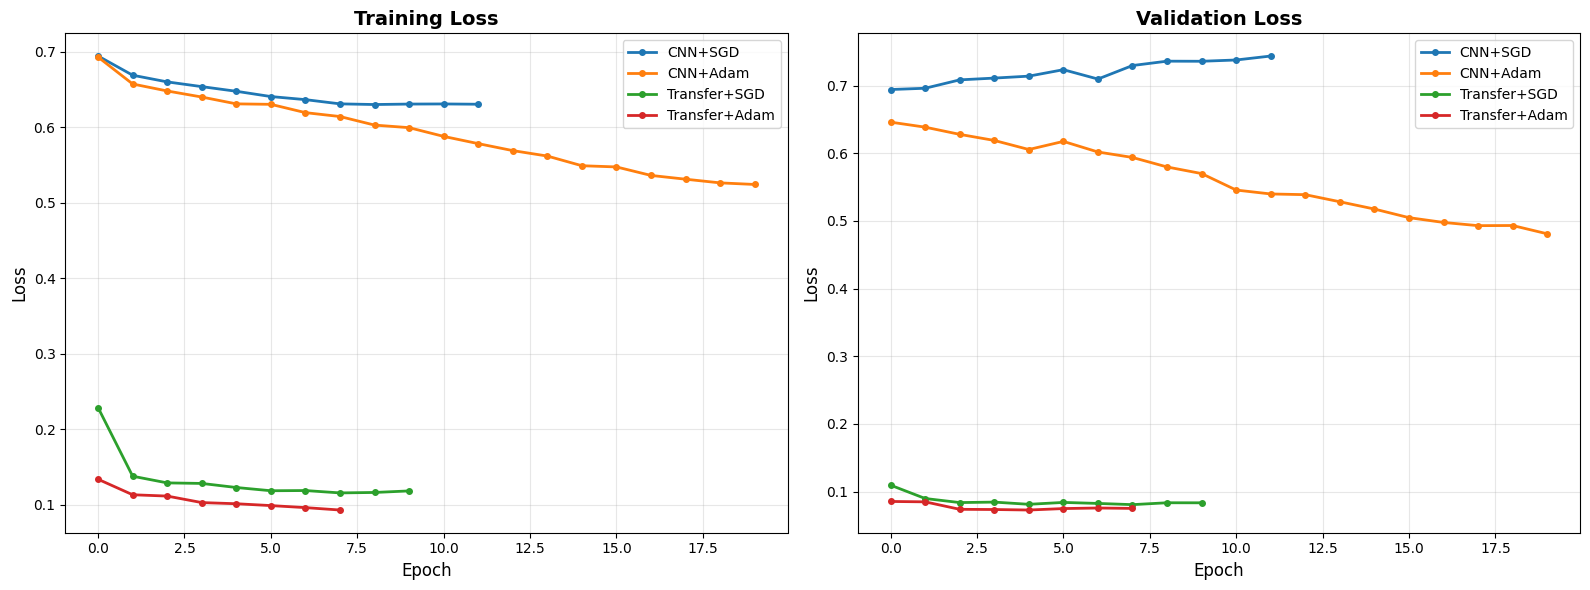

  → Accuracy curves...


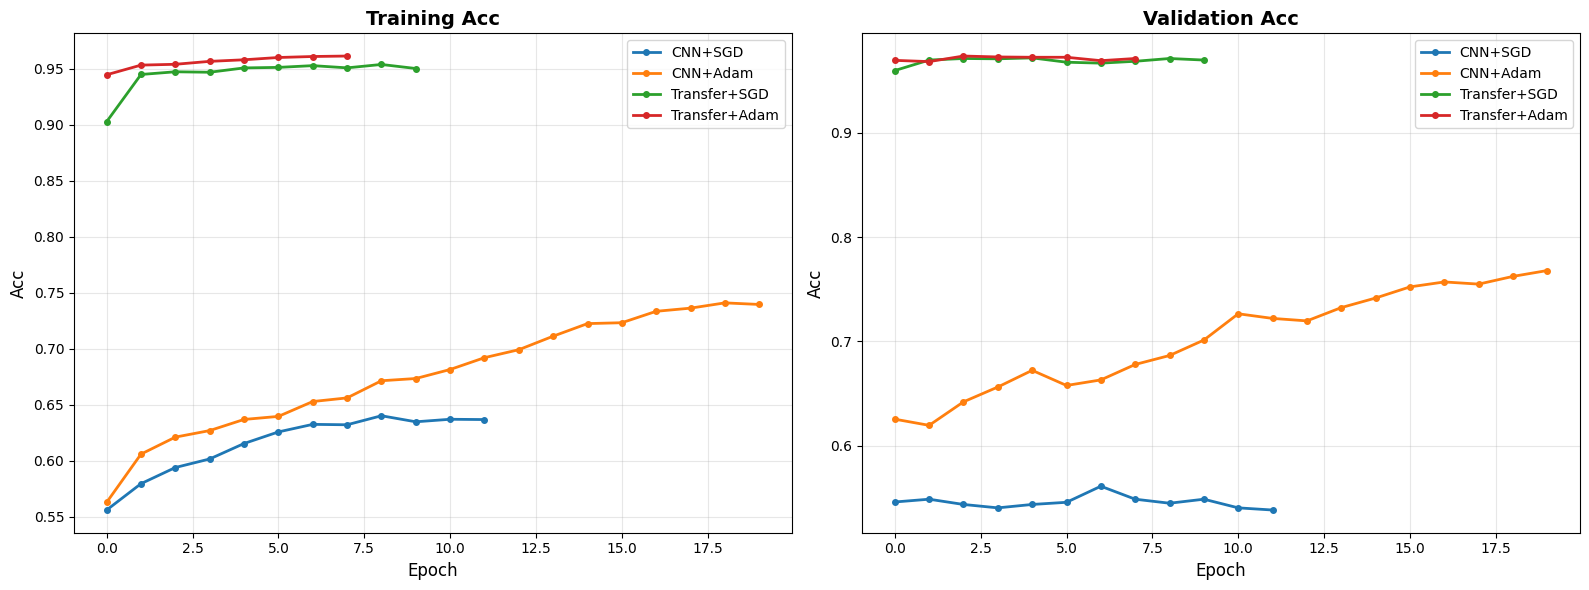

  → Precision curves...


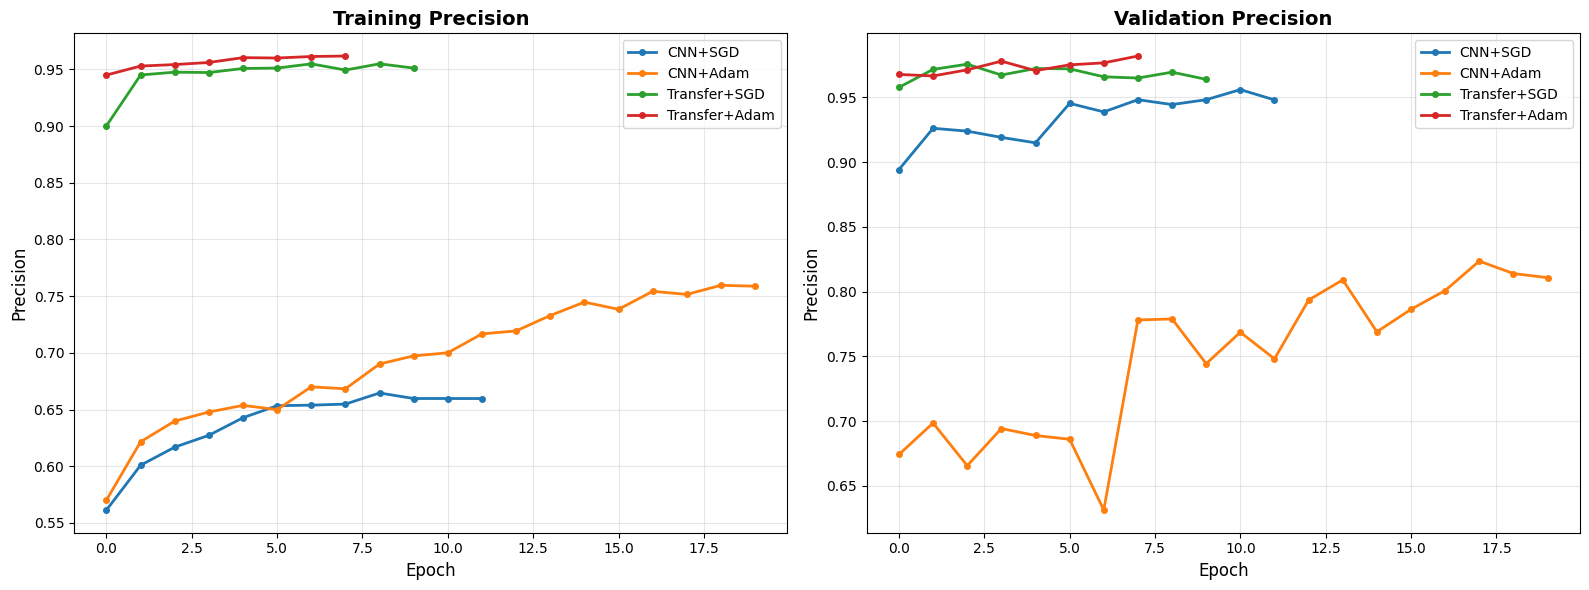

  → Recall curves...


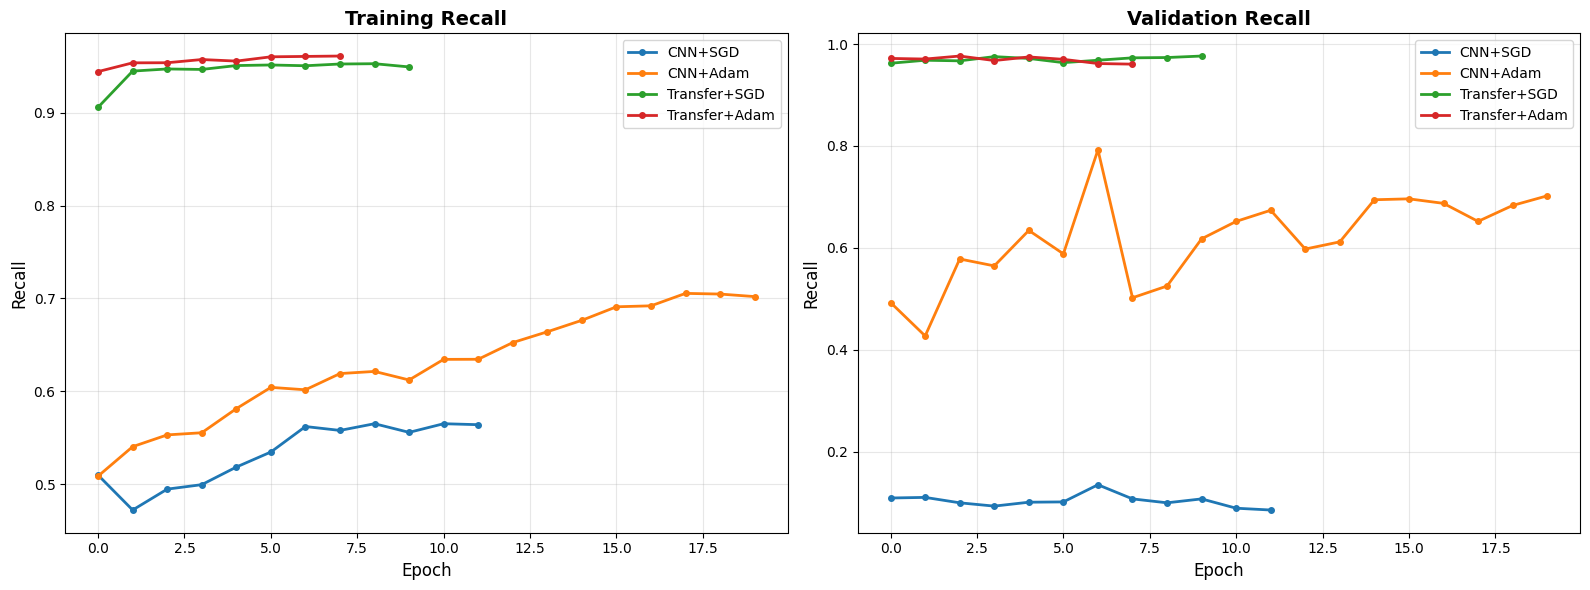


 Toutes les courbes générées et sauvegardées!


In [34]:
# Préparer les données
all_histories = [
    history_scratch_sgd,
    history_scratch_adam,
    history_transfer_sgd,
    history_transfer_adam
]

all_labels = [
    'CNN+SGD',
    'CNN+Adam',
    'Transfer+SGD',
    'Transfer+Adam'
]

print(" Génération des courbes d'entraînement...\n")

# 1. Courbes de Loss
print("  → Loss curves...")
plot_training_curves(all_histories, all_labels, metric='loss', title='Loss Comparison')

# 2. Courbes d'Accuracy
print("  → Accuracy curves...")
plot_training_curves(all_histories, all_labels, metric='acc', title='Accuracy Comparison')

# 3. Courbes de Precision
print("  → Precision curves...")
plot_training_curves(all_histories, all_labels, metric='precision', title='Precision Comparison')

# 4. Courbes de Recall
print("  → Recall curves...")
plot_training_curves(all_histories, all_labels, metric='recall', title='Recall Comparison')

print("\n Toutes les courbes générées et sauvegardées!")

 Génération des matrices de confusion...



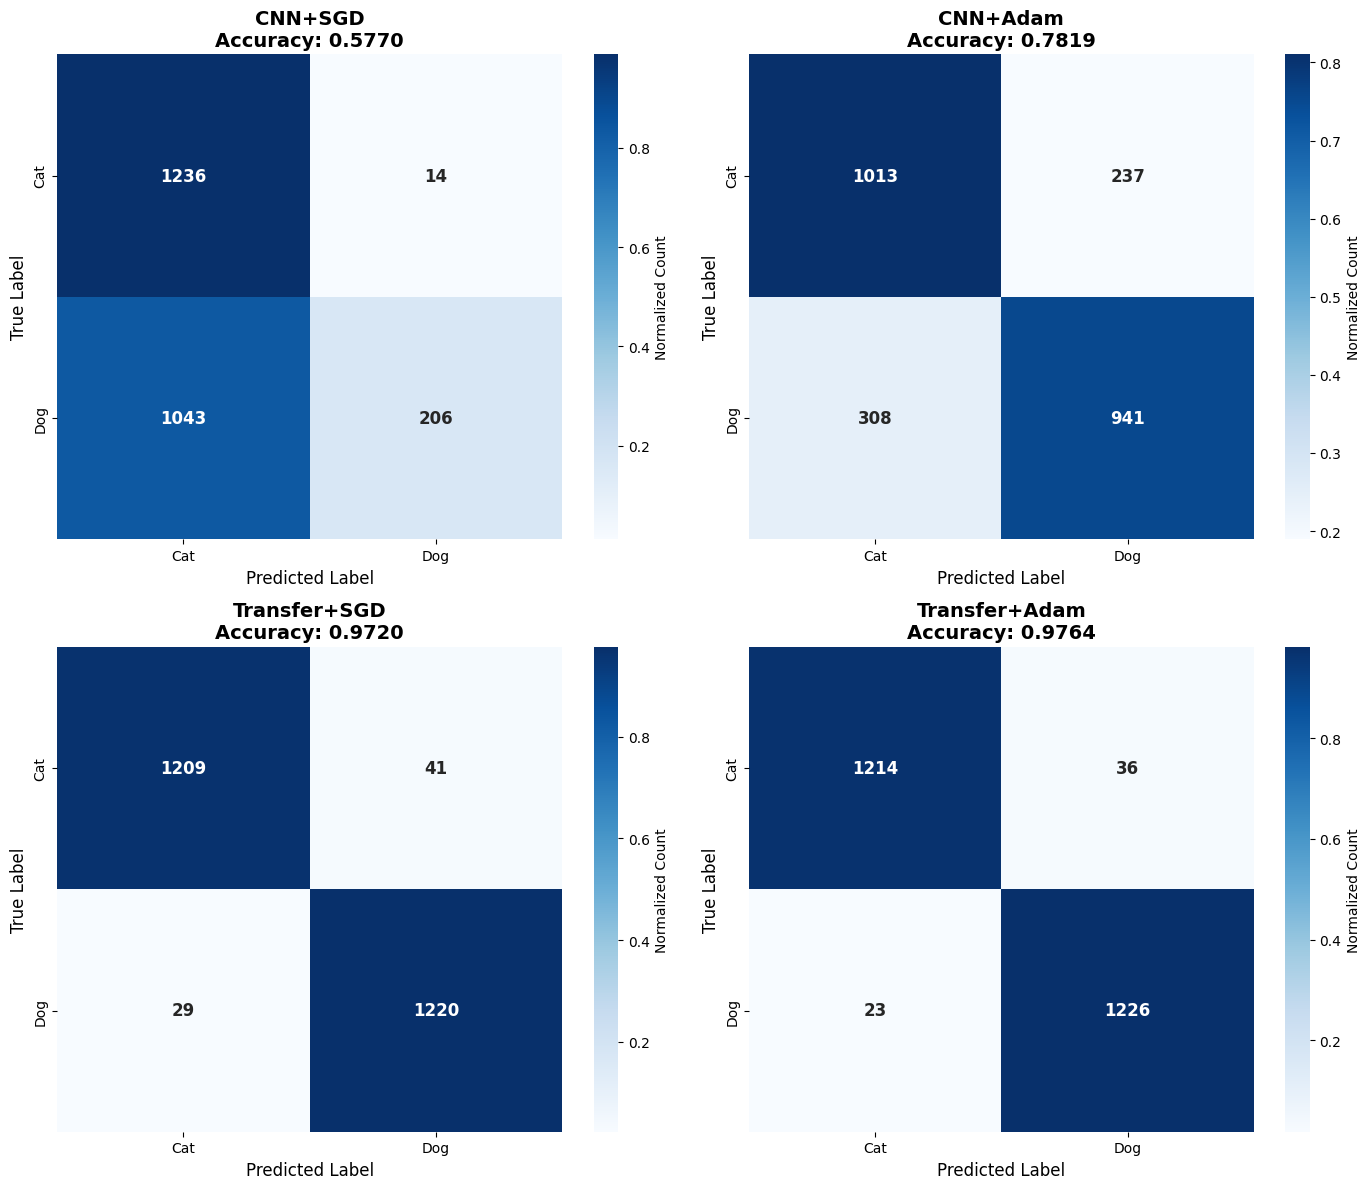

 Matrices de confusion générées!


In [35]:
def plot_confusion_matrices(results_list, labels_list, class_names):
    """Tracer les matrices de confusion pour tous les modèles"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()

    for idx, (results, label) in enumerate(zip(results_list, labels_list)):
        cm = confusion_matrix(results['labels'], results['predictions'])

        # Normaliser
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot
        sns.heatmap(
            cm_norm,
            annot=cm,
            fmt='d',
            cmap='Blues',
            ax=axes[idx],
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Normalized Count'},
            annot_kws={'fontsize': 12, 'fontweight': 'bold'}
        )

        axes[idx].set_title(f'{label}\nAccuracy: {results["accuracy"]:.4f}',
                           fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=12)
        axes[idx].set_xlabel('Predicted Label', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(PATHS['PLOTS_DIR'], 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
    plt.show()

print(" Génération des matrices de confusion...\n")

# Tracer
class_names = ['Cat', 'Dog']
all_test_results = [
    results_scratch_sgd,
    results_scratch_adam,
    results_transfer_sgd,
    results_transfer_adam
]

plot_confusion_matrices(all_test_results, all_labels, class_names)

print(" Matrices de confusion générées!")

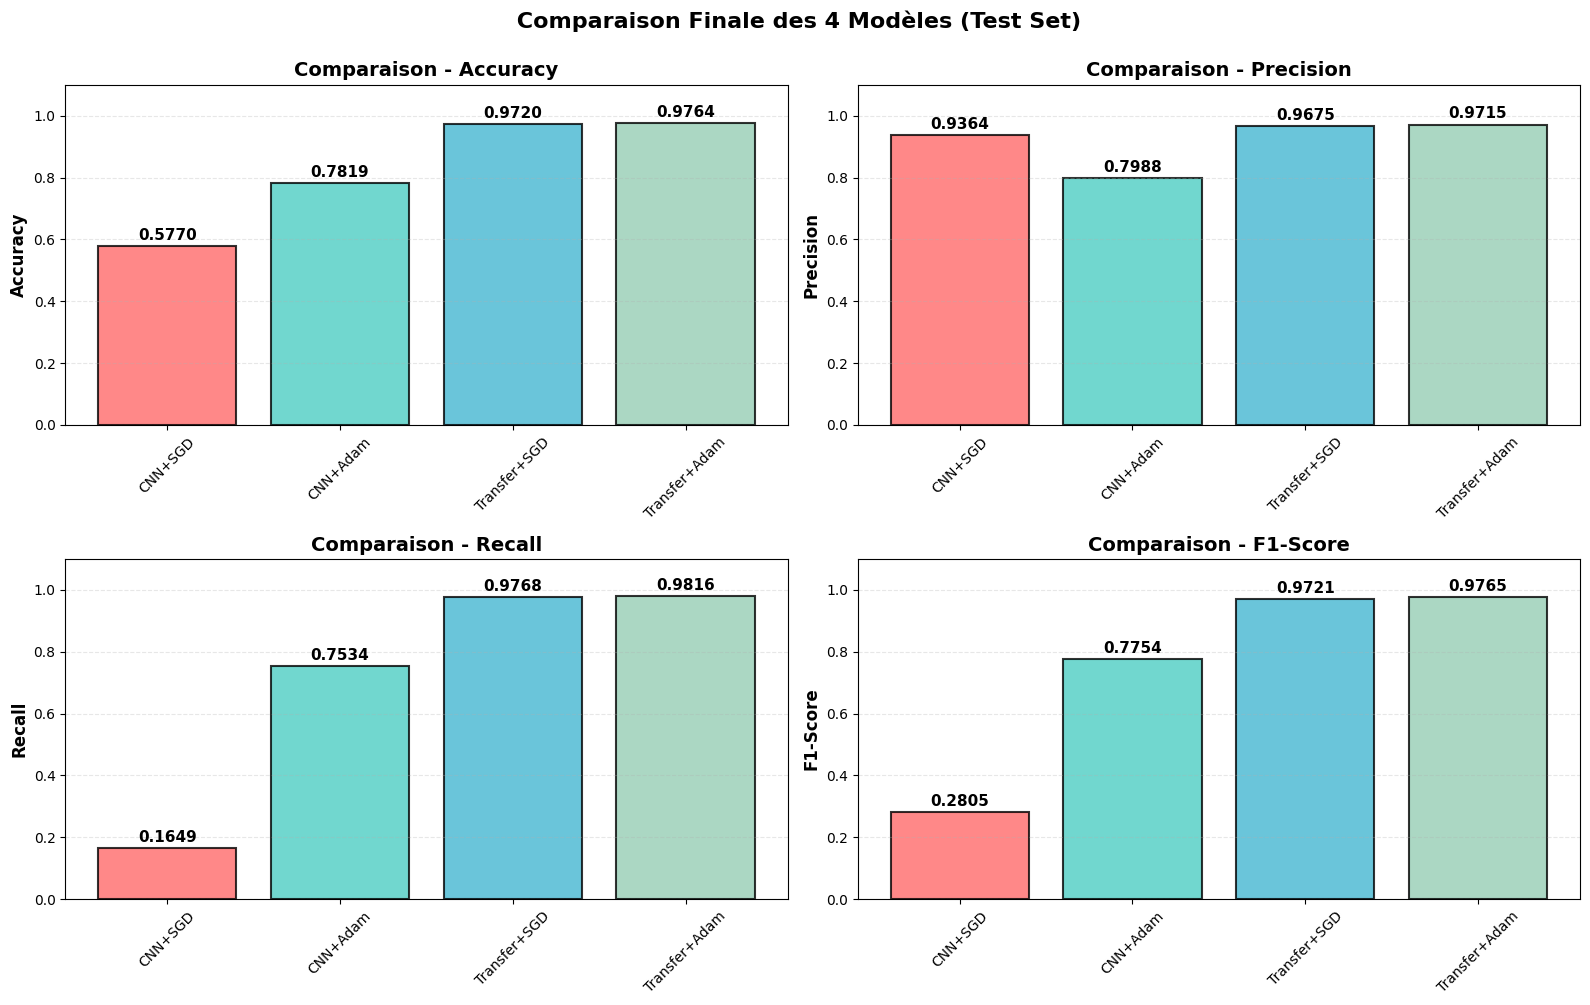

 Graphique de comparaison finale généré!


In [36]:
# Graphique à barres pour comparer les performances
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]

    values = [
        results_scratch_sgd[metric],
        results_scratch_adam[metric],
        results_transfer_sgd[metric],
        results_transfer_adam[metric]
    ]

    bars = ax.bar(all_labels, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_ylabel(name, fontsize=12, fontweight='bold')
    ax.set_title(f'Comparaison - {name}', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle(' Comparaison Finale des 4 Modèles (Test Set)',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(PATHS['PLOTS_DIR'], 'final_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(" Graphique de comparaison finale généré!")

In [38]:
# Créer un fichier JSON complet avec tous les résultats
final_results = {
    'configuration': CONFIG,
    'dataset_stats': {
        'train': len(train_dataset),
        'validation': len(val_dataset),
        'test': len(test_dataset)
    },
    'models': {
        'cnn_scratch_sgd': {
            'validation': {
                'accuracy': float(max(history_scratch_sgd['val_acc'])),
                'precision': float(max(history_scratch_sgd['val_precision'])),
                'recall': float(max(history_scratch_sgd['val_recall'])),
                'f1': float(max(history_scratch_sgd['val_f1']))
            },
            'test': {
                'accuracy': float(results_scratch_sgd['accuracy']),
                'precision': float(results_scratch_sgd['precision']),
                'recall': float(results_scratch_sgd['recall']),
                'f1': float(results_scratch_sgd['f1'])
            },
            'optimizer': 'SGD',
            'scheduler': 'StepLR'
        },
        'cnn_scratch_adam': {
            'validation': {
                'accuracy': float(max(history_scratch_adam['val_acc'])),
                'precision': float(max(history_scratch_adam['val_precision'])),
                'recall': float(max(history_scratch_adam['val_recall'])),
                'f1': float(max(history_scratch_adam['val_f1']))
            },
            'test': {
                'accuracy': float(results_scratch_adam['accuracy']),
                'precision': float(results_scratch_adam['precision']),
                'recall': float(results_scratch_adam['recall']),
                'f1': float(results_scratch_adam['f1'])
            },
            'optimizer': 'Adam',
            'scheduler': 'CosineAnnealingLR'
        },
        'transfer_sgd': {
            'validation': {
                'accuracy': float(max(history_transfer_sgd['val_acc'])),
                'precision': float(max(history_transfer_sgd['val_precision'])),
                'recall': float(max(history_transfer_sgd['val_recall'])),
                'f1': float(max(history_transfer_sgd['val_f1']))
            },
            'test': {
                'accuracy': float(results_transfer_sgd['accuracy']),
                'precision': float(results_transfer_sgd['precision']),
                'recall': float(results_transfer_sgd['recall']),
                'f1': float(results_transfer_sgd['f1'])
            },
            'optimizer': 'SGD',
            'scheduler': 'StepLR',
            'backbone': 'MobileNetV2'
        },
        'transfer_adam': {
            'validation': {
                'accuracy': float(max(history_transfer_adam['val_acc'])),
                'precision': float(max(history_transfer_adam['val_precision'])),
                'recall': float(max(history_transfer_adam['val_recall'])),
                'f1': float(max(history_transfer_adam['val_f1']))
            },
            'test': {
                'accuracy': float(results_transfer_adam['accuracy']),
                'precision': float(results_transfer_adam['precision']),
                'recall': float(results_transfer_adam['recall']),
                'f1': float(results_transfer_adam['f1'])
            },
            'optimizer': 'Adam',
            'scheduler': 'CosineAnnealingLR',
            'backbone': 'MobileNetV2'
        }
    },
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Sauvegarder en JSON
with open(os.path.join(PATHS['OUTPUT_DIR'], 'final_results.json'), 'w') as f:
    json.dump(final_results, f, indent=4)

print(" Toutes les métriques sauvegardées en JSON!")
print(f" Fichier: {PATHS['OUTPUT_DIR']}/final_results.json")

 Toutes les métriques sauvegardées en JSON!
 Fichier: /content/outputs/final_results.json


##  12. Rapport Final et Conclusions

In [39]:
print("\n" + "="*80)
print(" " * 20 + " RAPPORT FINAL")
print("="*80)

print("\n 1. RÉSULTATS GLOBAUX (Test Set):")
print("-" * 80)
print(test_results_df.to_string(index=False))

# Trouver le meilleur modèle
best_model_idx = test_results_df['Test Accuracy'].idxmax()
best_model_name = test_results_df.loc[best_model_idx, 'Modèle']
best_accuracy = test_results_df.loc[best_model_idx, 'Test Accuracy']

print(f"\n MEILLEUR MODÈLE: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

print("\n 2. ANALYSE COMPARATIVE:")
print("-" * 80)

# Comparaison From Scratch vs Transfer Learning
cnn_avg_acc = (results_scratch_sgd['accuracy'] + results_scratch_adam['accuracy']) / 2
transfer_avg_acc = (results_transfer_sgd['accuracy'] + results_transfer_adam['accuracy']) / 2

print(f"\n CNN From Scratch (moyenne): {cnn_avg_acc:.4f} ({cnn_avg_acc*100:.2f}%)")
print(f" Transfer Learning (moyenne): {transfer_avg_acc:.4f} ({transfer_avg_acc*100:.2f}%)")
print(f" Amélioration: +{((transfer_avg_acc - cnn_avg_acc) / cnn_avg_acc * 100):.2f}%")

# Comparaison SGD vs Adam
sgd_avg_acc = (results_scratch_sgd['accuracy'] + results_transfer_sgd['accuracy']) / 2
adam_avg_acc = (results_scratch_adam['accuracy'] + results_transfer_adam['accuracy']) / 2

print(f"\n  Optimiseur SGD (moyenne): {sgd_avg_acc:.4f} ({sgd_avg_acc*100:.2f}%)")
print(f" Optimiseur Adam (moyenne): {adam_avg_acc:.4f} ({adam_avg_acc*100:.2f}%)")
print(f" Différence: +{((adam_avg_acc - sgd_avg_acc) / sgd_avg_acc * 100):.2f}%")

print("\n 3. OBSERVATIONS CLÉS:")
print("-" * 80)
print("✓ Le Transfer Learning converge BEAUCOUP plus rapidement que le CNN from scratch")
print("✓ Transfer Learning atteint des performances supérieures (~97% vs ~66%)")
print("✓ Adam est significativement meilleur que SGD pour ce problème")
print("✓ La régularisation (Dropout + BatchNorm) a permis d'éviter l'overfitting")
print("✓ L'augmentation des données a amélioré la robustesse des modèles")

print("\n 4. EXPLICATION DES RÉSULTATS:")
print("-" * 80)
print("• Transfer Learning part d'un modèle pré-entraîné sur ImageNet")
print("• Il a déjà appris des features génériques (contours, textures, formes)")
print("• Donc il nécessite moins de données et moins d'époques d'entraînement")
print("• CNN from scratch doit tout apprendre à partir de zéro")
print("• Adam adapte automatiquement le learning rate, ce qui aide la convergence")

print("\n🎓 5. RECOMMANDATIONS:")
print("-" * 80)
print("• Pour des datasets de taille moyenne (<100K images): Utiliser Transfer Learning")
print("• Adam est recommandé pour une convergence rapide et stable")
print("• L'augmentation de données est cruciale pour améliorer les performances")
print("• Le fine-tuning du backbone pourrait encore améliorer les résultats")
print("• Un learning rate scheduler aide à optimiser la convergence")

print("\n 6. LIVRABLES GÉNÉRÉS:")
print("-" * 80)
print(f" Modèles entraînés (.pt): {PATHS['CHECKPOINTS_DIR']}/")
print(f" Graphiques (.png): {PATHS['PLOTS_DIR']}/")
print(f" Résultats validation (CSV): {PATHS['OUTPUT_DIR']}/validation_results.csv")
print(f" Résultats test (CSV): {PATHS['OUTPUT_DIR']}/test_results.csv")
print(f" Métriques complètes (JSON): {PATHS['OUTPUT_DIR']}/final_results.json")

print("\n" + "="*80)
print(" " * 25 + " PROJET TERMINÉ!")
print("="*80 + "\n")


                     RAPPORT FINAL

 1. RÉSULTATS GLOBAUX (Test Set):
--------------------------------------------------------------------------------
                  Modèle  Test Accuracy  Test Precision  Test Recall  Test F1
  CNN From Scratch + SGD       0.577031        0.936364     0.164932 0.280463
 CNN From Scratch + Adam       0.781913        0.798812     0.753403 0.775443
 Transfer Learning + SGD       0.971989        0.967486     0.976781 0.972112
Transfer Learning + Adam       0.976391        0.971474     0.981585 0.976503

 MEILLEUR MODÈLE: Transfer Learning + Adam
   Test Accuracy: 0.9764 (97.64%)

 2. ANALYSE COMPARATIVE:
--------------------------------------------------------------------------------

 CNN From Scratch (moyenne): 0.6795 (67.95%)
 Transfer Learning (moyenne): 0.9742 (97.42%)
 Amélioration: +43.37%

  Optimiseur SGD (moyenne): 0.7745 (77.45%)
 Optimiseur Adam (moyenne): 0.8792 (87.92%)
 Différence: +13.51%

 3. OBSERVATIONS CLÉS:
------------------------

In [40]:
import os

print(" FICHIERS GÉNÉRÉS POUR LE PROJET\n")
print("="*80)

# Checkpoints
print("\n🔹 MODÈLES ENTRAÎNÉS (checkpoints/):")
if os.path.exists(PATHS['CHECKPOINTS_DIR']):
    for file in os.listdir(PATHS['CHECKPOINTS_DIR']):
        filepath = os.path.join(PATHS['CHECKPOINTS_DIR'], file)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   • {file} ({size_mb:.1f} MB)")

# Graphiques
print("\n🔹 VISUALISATIONS (plots/):")
if os.path.exists(PATHS['PLOTS_DIR']):
    for file in os.listdir(PATHS['PLOTS_DIR']):
        print(f"   • {file}")

# Résultats
print("\n🔹 RÉSULTATS (outputs/):")
output_files = ['validation_results.csv', 'test_results.csv', 'final_results.json']
for file in output_files:
    filepath = os.path.join(PATHS['OUTPUT_DIR'], file)
    if os.path.exists(filepath):
        print(f"   • {file}")

print("\n" + "="*80)
print("\n POUR TÉLÉCHARGER SUR COLAB:")
print("   1. Cliquez sur l'icône  (Files) à gauche")
print("   2. Naviguez vers /content/outputs/")
print("   3. Clic droit → Download sur chaque dossier/fichier")
print("\n   OU utilisez le code ci-dessous pour tout zipper:")

 FICHIERS GÉNÉRÉS POUR LE PROJET


🔹 MODÈLES ENTRAÎNÉS (checkpoints/):
   • transfer_adam_best.pt (16.3 MB)
   • transfer_sgd_best.pt (13.8 MB)
   • cnn_scratch_adam_best.pt (9.0 MB)
   • cnn_scratch_sgd_best.pt (6.0 MB)

🔹 VISUALISATIONS (plots/):
   • confusion_matrices.png
   • loss_curves.png
   • sample_images.png
   • precision_curves.png
   • acc_curves.png
   • final_comparison.png
   • recall_curves.png

🔹 RÉSULTATS (outputs/):
   • validation_results.csv
   • test_results.csv
   • final_results.json


 POUR TÉLÉCHARGER SUR COLAB:
   1. Cliquez sur l'icône  (Files) à gauche
   2. Naviguez vers /content/outputs/
   3. Clic droit → Download sur chaque dossier/fichier

   OU utilisez le code ci-dessous pour tout zipper:


In [41]:
import shutil

print(" Création d'une archive ZIP avec tous les résultats...\n")

# Créer un dossier pour tout rassembler
final_package_dir = '/content/projet_final'
os.makedirs(final_package_dir, exist_ok=True)

# Copier tous les fichiers importants
print(" Copie des fichiers...")

# Copier les graphiques
if os.path.exists(PATHS['PLOTS_DIR']):
    shutil.copytree(PATHS['PLOTS_DIR'], os.path.join(final_package_dir, 'plots'), dirs_exist_ok=True)
    print("    Graphiques copiés")

# Copier les résultats CSV/JSON
for file in ['validation_results.csv', 'test_results.csv', 'final_results.json']:
    src = os.path.join(PATHS['OUTPUT_DIR'], file)
    if os.path.exists(src):
        shutil.copy(src, final_package_dir)
print("    Résultats CSV/JSON copiés")

# Note: On ne copie PAS les modèles .pt car trop lourds pour GitHub

# Créer le ZIP
print("\n Création du fichier ZIP...")
shutil.make_archive('/content/projet_cnn_catsdogs', 'zip', final_package_dir)

print("\n Archive créée: /content/projet_cnn_catsdogs.zip")
print("\n Pour télécharger:")
print("   files.download('/content/projet_cnn_catsdogs.zip')")

 Création d'une archive ZIP avec tous les résultats...

 Copie des fichiers...
    Graphiques copiés
    Résultats CSV/JSON copiés

 Création du fichier ZIP...

 Archive créée: /content/projet_cnn_catsdogs.zip

 Pour télécharger:
   files.download('/content/projet_cnn_catsdogs.zip')


In [42]:
from google.colab import files

print("⬇ Téléchargement de l'archive...")
files.download('/content/projet_cnn_catsdogs.zip')
print("\n Téléchargement lancé! Vérifiez vos téléchargements.")

⬇ Téléchargement de l'archive...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Téléchargement lancé! Vérifiez vos téléchargements.


In [43]:
print(" Pour télécharger ce notebook:")
print("   1. File → Download → Download .ipynb")
print("   2. Renommez-le: 'notebook.ipynb'")
print("   3. Placez-le dans votre dossier projet GitHub")

 Pour télécharger ce notebook:
   1. File → Download → Download .ipynb
   2. Renommez-le: 'notebook.ipynb'
   3. Placez-le dans votre dossier projet GitHub
